# 1. Introduction: Motivation and Relevance

## 1.1 Installing and importing packages

In [1]:
conda install numpy pandas matplotlib seaborn folium xlrd olefile geopandas geopy tqdm pyclustering osmnx MiniSom hdbscan


Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - pyclustering

Current channels:

  - defaults
  - https://conda.anaconda.org/conda-forge

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install  pysal

In [3]:
import pandas as pd
import folium
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import olefile
import scipy
import minisom
import hdbscan
import geopandas as gpd
from shapely.geometry import Point
import folium
from scipy import stats
from folium.plugins import MarkerCluster
import requests
from scipy.spatial.distance import cdist 
from collections import defaultdict  
from bs4 import BeautifulSoup
from collections import OrderedDict
import geopy
from numpy import unique, where
from sklearn.cluster import Birch
from matplotlib import pyplot
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing, cluster
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import BayesianGaussianMixture


## Dataset №1 *"Corporate Social Responsibility, Sustainable Development, ESG, and the Fight Against Climate Change – 2022-2023"*

## 1.2 Dataset №1 Preprocessing

In [4]:
path = 'Datasets/table_dataset20_data(1).xls'

with open(path, 'rb') as file:
    ole = olefile.OleFileIO(file)
    
    if ole.exists('Workbook'):
        workbook_stream = ole.openstream('Workbook')
        
        excel_data = pd.read_excel(workbook_stream, sheet_name=None, engine='xlrd')
        dfs = []
        
        for sheet_name, df in excel_data.items():
            #Skipping the first row and set the third row as column names
            df.columns = df.iloc[2]
            df = df.iloc[3:].reset_index(drop=True) 
            dfs.append(df)
        
        ESG_world = pd.concat(dfs, ignore_index=True)
        ESG_world.columns.values[0] = 'Страны'
        ESG_world.columns.name = None
        #Getting rid of irrelevant symbols
        ESG_world = ESG_world.rename(columns={"Энергоемкость ВВП, долл за кг нефтяного эквиваленты (в постоянных ценах 2017 г.)\t":"Энергоемкость ВВП, долл за кг нефтяного эквиваленты (в постоянных ценах 2017 г.)"})
        #The Year column was added to keep track of dates and not to mix everything up when cleaning the dataset
        ESG_world = ESG_world.assign(Год=[year for year in range(2015, 2023) for _ in range(len(ESG_world) // 8)])
        #Correcting the values; Source: NUMBEO - Pollution Index by Country
        indexes_to_update = ESG_world[(ESG_world['Страны'] == 'Россия') & (ESG_world['Год'].isin([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]))].index
        ESG_world.loc[indexes_to_update, 'Индекс загрязнения окружающей среды, баллы 1-100'] = [72.77, 64.49, 63.04, 63.26, 62.80, 62.79, 62.32, 61.80]



ESG_world.tail()

,Страны,"Выбросы углерода при потреблении электроэнергии, МтCO₂/ТВтч","Доля возобновляемой энергии в совокупном предложении первичной энергии в стране, %.","Инвестиции в энергетическую инфраструктуру на базе механизма государственно-частного партнерства, долл.","Индекс загрязнения окружающей среды, баллы 1-100","Индекс изменения климата, баллы 1-100","Индекс устойчивого развития энергетики, баллы 1-100","Индекс энергетической трилеммы, баллы 1-100","Предпринимательская культура, баллы 1-100","Природная рента в ВВП, % ВВП",...,"Свобода международной торговли, баллы 1-100","Свобода международной торговли, диверсификация и объем рынка, баллы 1-100","Требования по охране окружающей среды, баллы 1-100","Требовательность потребителей, баллы 1-100","Уровень рыночной конкуренции, баллы 1-100","Экологическая сертификация качества продукции в экономике, баллы 1-100","Экологическая эффективность экономики, баллы 1-100","Электрификация домохозяйств, %","Энергоемкость ВВП, долл за кг нефтяного эквиваленты (в постоянных ценах 2017 г.)",Год
2027,Южная Джорджия и Южные Сандвичевы острова,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
2028,Южная Осетия,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
2029,Южный Судан,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
2030,Ямайка,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23,NaN,NaN,NaN,1.8,45.6,NaN,8.7,2022
2031,Япония,NaN,NaN,NaN,38.82,85.27,NaN,NaN,NaN,NaN,...,NaN,93.3,NaN,NaN,NaN,3.4,57.2,NaN,12.9,2022


In [5]:
# The number of NaN values in each column
ESG_world.isnull().sum().sort_values(ascending=False)

Требования по охране окружающей среды, баллы 1-100                                                         1895
Регулирование возобновляемой энергии, баллы 1-100                                                          1893
Регулирование энергоэффективности, баллы 1-100                                                             1893
Индекс энергетической трилеммы, баллы 1-100                                                                1781
Инвестиции в энергетическую инфраструктуру на базе механизма государственно-частного партнерства, долл.    1772
Уровень рыночной конкуренции, баллы 1-100                                                                  1757
Предпринимательская культура, баллы 1-100                                                                  1757
Свобода международной торговли, баллы 1-100                                                                1753
Индекс изменения климата, баллы 1-100                                                                   

/Users/stacey/anaconda3/envs/diploma/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/stacey/anaconda3/envs/diploma/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


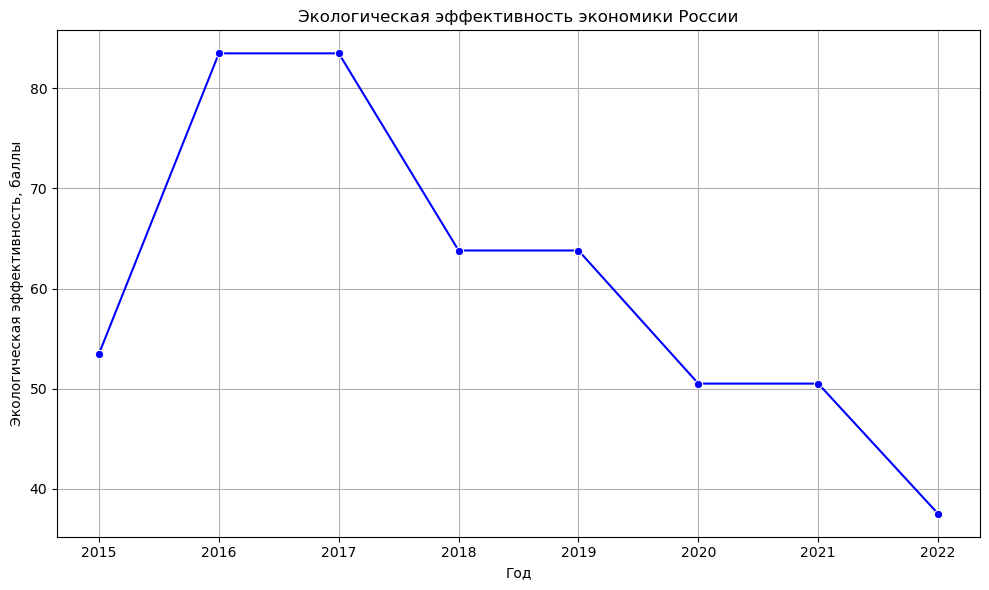

In [6]:
ESG_world_russia = ESG_world[ESG_world['Страны'] == 'Россия']
plt.figure(figsize=(10, 6))
sns.lineplot(data=ESG_world_russia, x='Год', y='Экологическая эффективность экономики, баллы 1-100', marker='o', color='b')
plt.title('Экологическая эффективность экономики России')
plt.xlabel('Год')
plt.ylabel('Экологическая эффективность, баллы')
plt.grid(True)
plt.tight_layout() 
plt.show()

In [7]:
# Delete all rows where there are all Nans
ESG_world.dropna(subset=ESG_world.columns.difference(['Страны', 'Год']), how='all', inplace=True)

In [8]:
# ESG_world.dropna(axis=1, how='all', inplace=True)

In [9]:
ESG_world.shape

(1616, 23)

The plots presented below were generated using Tableau.

<div style="display: flex;">
    <div style="flex: 50%; padding: 5px;">
        <img src="Figures & Plots/Screenshot 2024-04-01 at 21.23.33.png" alt="Image 1" style="width: 100%;">
    </div>
    <div style="flex: 50%; padding: 5px;">
        <img src="Figures & Plots/Screenshot 2024-04-01 at 21.22.44.png" alt="Image 2" style="width: 100%;">
    </div>
</div>


<img src="Figures & Plots/Screenshot 2024-04-01 at 21.23.08.png" alt="Image" style="width: 60%;">

# 2. Main part

## Dataset №2 *"Facilities with Adverse Effects on the Environment: Pollutants, Emissions, and Discharges"*

## 2.1 EDA and Data-Preprocessing

In [10]:
objects = pd.read_csv('Datasets/data_onv_register_101_v20231124_csv 2/objects.csv',  delimiter=';', low_memory=False)

In [11]:
sources_stationary = pd.read_csv('Datasets/data_onv_register_101_v20231124_csv 2/sources_stationary.csv',  delimiter=';', low_memory=False)


In [12]:
sources_stationary.tail(5)

,onv_id,air_pollutant_code,sum,name
4156483,10439,602.0,0.097661,Бензол
4156484,10439,616.0,0.012988,"Диметилбензол (Ксилол) (смесь изомеров о-, м-,..."
4156485,10439,621.0,0.097189,Метилбензол (Толуол)
4156486,10439,627.0,0.002687,Этилбензол
4156487,10439,2754.0,0.170231,Алканы C12-C19 /в пересчете на суммарный орган...


In [13]:
objects.tail(5)

,onv_id,number,name,address,oktmo,registry_type,registry_category,supervisory_territory_org_id,okveds,exclusion_date,...,request_organization_egrul_registration_date,request_organization_inn,request_organization_kpp,is_resident,legal_address_address,legal_address_post_index,legal_address_oktmo,latitude,longitude,is_excluded
477215,1043,88-0112-000050-П,"Йошкар-Олинская ТЭЦ-2 Филиала ""Марий Эл и Чува...","Республика Марий Эл, г Йошкар-Ола, ул Крылова,...",88701000.0,Federal,2.0,6,"{33.12,35.11.1,35.11.4,35.30.1,35.30.11,35.30....",NaN,...,2015-06-14 21:00:00,6315376946,502401001,t,"Московская область, Красногорский район, Моско...",143421,46744000.0,56.611971,47.847894,f
477216,946,88-0112-000048-П,конюшня,"Республика Марий Эл, Звениговский район, п.Кра...",88612162.0,Federal,3.0,6,{92.53},NaN,...,2012-03-28 20:00:00,1203000985,120301001,t,"Республика Марий Эл, Звениговский район, п.Кра...",425090,88612162.0,56.159429,48.324755,f
477217,945,88-0112-000047-П,гаражные боксы,"Республика Марий Эл, Звениговский район, п.Кра...",88612162.0,Federal,3.0,6,{92.53},NaN,...,2012-03-28 20:00:00,1203000985,120301001,t,"Республика Марий Эл, Звениговский район, п.Кра...",425090,88612162.0,56.158133,48.321330,f
477218,942,88-0112-000046-П,административное здание,"Республика Марий Эл, Звениговский район, п.Кра...",88612162.0,Federal,3.0,6,{92.53},NaN,...,2012-03-28 20:00:00,1203000985,120301001,t,"Республика Марий Эл, Звениговский район, п.Кра...",425090,88612162.0,56.160665,48.311696,f
477219,342,88-0112-000041-П,Производственная площадка,"Республика Марий Эл, г. Йошкар-Ола, ул. Машино...",88701000.0,Federal,3.0,6,{38.1},NaN,...,2006-07-11 20:00:00,1207008914,121501001,t,"Республика Марий Эл, город Йошкар-Ола, улица М...",424007,88701000.0,56.620736,47.840496,f


In [14]:
#there are many irrelevant variables
objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477220 entries, 0 to 477219
Data columns (total 25 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   onv_id                                        477220 non-null  int64  
 1   number                                        477220 non-null  object 
 2   name                                          477056 non-null  object 
 3   address                                       477094 non-null  object 
 4   oktmo                                         476699 non-null  float64
 5   registry_type                                 476907 non-null  object 
 6   registry_category                             477166 non-null  float64
 7   supervisory_territory_org_id                  477220 non-null  int64  
 8   okveds                                        477113 non-null  object 
 9   exclusion_date                                33

In [15]:
objects.shape

(477220, 25)

In [16]:
sources_stationary.shape

(4156488, 4)

In [17]:
# Get a list of unique onv_id from sources_stationary
unique_ids_sources_stationary = set(sources_stationary['onv_id'].unique())

# Remove observations from objects if their onv_id is not in sources_stationary
objects = objects[objects['onv_id'].isin(unique_ids_sources_stationary)]


In [18]:
len(objects['onv_id'].unique())

392765

In [19]:
len(sources_stationary['onv_id'].unique())

392765

In [20]:
# Find dublicates
duplicates = objects[objects.duplicated('onv_id', keep=False)]
sorted_objects = duplicates.sort_values(by='onv_id')
sorted_objects.shape

(1058, 25)

In [21]:
# Step 1: Find and save only the first occurrence of duplicate onv_id
duplicates = objects[objects.duplicated('onv_id', keep='first')]
duplicate_ids = duplicates['onv_id'].unique()

# Step 2: Remove duplicates from objects, leaving only the first occurrence
objects = objects.drop_duplicates('onv_id', keep='first')

In [22]:
objects.shape

(392765, 25)

In [23]:
objects.isnull().sum()

onv_id                                               0
number                                               0
name                                                58
address                                             61
oktmo                                              258
registry_type                                      265
registry_category                                   44
supervisory_territory_org_id                         0
okveds                                             101
exclusion_date                                  364719
registry_category_id                                44
registry_type_id                                   180
supervision_level                                    2
onv_region_id                                        0
request_organization_full_name                       1
request_organization_egrul_registration_date     53680
request_organization_inn                            52
request_organization_kpp                         27984
is_residen

In [24]:
pd.set_option('display.max_columns', None) 
objects.tail() 

,onv_id,number,name,address,oktmo,registry_type,registry_category,supervisory_territory_org_id,okveds,exclusion_date,registry_category_id,registry_type_id,supervision_level,onv_region_id,request_organization_full_name,request_organization_egrul_registration_date,request_organization_inn,request_organization_kpp,is_resident,legal_address_address,legal_address_post_index,legal_address_oktmo,latitude,longitude,is_excluded
477215,1043,88-0112-000050-П,"Йошкар-Олинская ТЭЦ-2 Филиала ""Марий Эл и Чува...","Республика Марий Эл, г Йошкар-Ола, ул Крылова,...",88701000.0,Federal,2.0,6,"{33.12,35.11.1,35.11.4,35.30.1,35.30.11,35.30....",NaN,2.0,1.0,Federal,88,"Публичное акционерное общество ""Т Плюс""",2015-06-14 21:00:00,6315376946,502401001,t,"Московская область, Красногорский район, Моско...",143421,46744000.0,56.611971,47.847894,f
477216,946,88-0112-000048-П,конюшня,"Республика Марий Эл, Звениговский район, п.Кра...",88612162.0,Federal,3.0,6,{92.53},NaN,3.0,1.0,Federal,88,Федеральное государственное бюджетное учрежден...,2012-03-28 20:00:00,1203000985,120301001,t,"Республика Марий Эл, Звениговский район, п.Кра...",425090,88612162.0,56.159429,48.324755,f
477217,945,88-0112-000047-П,гаражные боксы,"Республика Марий Эл, Звениговский район, п.Кра...",88612162.0,Federal,3.0,6,{92.53},NaN,3.0,1.0,Federal,88,Федеральное государственное бюджетное учрежден...,2012-03-28 20:00:00,1203000985,120301001,t,"Республика Марий Эл, Звениговский район, п.Кра...",425090,88612162.0,56.158133,48.321330,f
477218,942,88-0112-000046-П,административное здание,"Республика Марий Эл, Звениговский район, п.Кра...",88612162.0,Federal,3.0,6,{92.53},NaN,3.0,1.0,Federal,88,Федеральное государственное бюджетное учрежден...,2012-03-28 20:00:00,1203000985,120301001,t,"Республика Марий Эл, Звениговский район, п.Кра...",425090,88612162.0,56.160665,48.311696,f
477219,342,88-0112-000041-П,Производственная площадка,"Республика Марий Эл, г. Йошкар-Ола, ул. Машино...",88701000.0,Federal,3.0,6,{38.1},NaN,3.0,1.0,Federal,88,"Общество с ограниченной ответственностью ""Чист...",2006-07-11 20:00:00,1207008914,121501001,t,"Республика Марий Эл, город Йошкар-Ола, улица М...",424007,88701000.0,56.620736,47.840496,f


In [25]:
print("Number of unique facilities:", len(objects.name.unique()))
print("Number of unique onv_ids:", len(objects.onv_id.unique()))
print("Number of unique okveds:", len(objects.okveds.unique()))
print("Number of unique regions:", len(objects.onv_region_id.unique()))

Number of unique facilities: 291553
Number of unique onv_ids: 392765
Number of unique okveds: 43399
Number of unique regions: 85


In [26]:
objects.onv_region_id.unique()

array([ 82,   7,  89,  27,  22,  86,  81,  53,  45,  18,  36,  73,  60,
        15,  66,  78,  65,  94,  52,  98,  28,  80,  19,  71,  68,  76,
        14,  34,  46,   3,  42, 719,  92,  63,  57,  50,  32, 718,  17,
        40,  38,  33,  67,  12,  56,  41,  88,   1,  54,  10,  58,  49,
        11,  35,  69,  70,  75,  25,  99,  47,   4,   8,  95,  24,  97,
        37,  64,  20,  29,  44,  61,   5,  93,  30,  83,  96,  90,  87,
        79,  84, 118,  85,  91,  26,  77])

In [27]:
columns_to_check = ['onv_id', 'latitude', 'longitude', 'is_resident', 'registry_type_id', 'supervisory_territory_org_id', 'supervision_level', 'okveds', 'name', 'request_organization_full_name', 'registry_category', 'onv_region_id']
cleaned_objects = objects.dropna(subset=columns_to_check)
removed_objects_indices = objects.loc[objects.index.difference(cleaned_objects.index), 'onv_id'].tolist()


In [28]:
len(removed_objects_indices)

1311

In [29]:
# Leave only the required columns in the objects table

selected_columns = ['onv_id', 'latitude', 'longitude', 'is_resident', 'registry_type_id', 'supervisory_territory_org_id', 'supervision_level', 'okveds', 'name', 'request_organization_full_name', 'registry_category', 'onv_region_id']
cleaned_objects = cleaned_objects[selected_columns]

In [30]:
# Dictionary with OKTMO codes for each economic area
economic_regions = {
    'Central': [45, 15, 17, 29, 34, 46, 54, 61, 66, 28, 70, 78, 24],
    'Central-Chernozem': [14, 20, 38, 42, 68],
    'Eastern Siberian': [93, 95, 4, 25],
    'Far Eastern': [81, 76, 98, 30, 5, 8, 10, 44, 64, 99, 77],
    'Northern': [86, 87, 11, 19, 47, 118],
    'North Caucasus': [79, 82, 26, 83, 91, 35, 90, 96, 3, 7, 60, 67],
    'Northwestern': [41, 49, 58, 40],
    'Volga-Vyatka': [85, 92, 12, 18, 56, 36, 63, 73],
    'Ural': [80, 94, 57, 38, 53, 65, 75, 37], #added Kurgan
    'West Siberian': [88, 89, 97, 33, 22],
    'Western': [84, 1, 32, 50, 52, 69, 71, 718, 719],
    'Kaliningrad': [27]
}


In [31]:
# Create new columns for each economic area and set flags
for region, oktmo_codes in economic_regions.items():
    cleaned_objects[region] = cleaned_objects['onv_region_id'].isin(oktmo_codes).astype(int)


In [32]:
cleaned_objects.isnull().sum()

onv_id                            0
latitude                          0
longitude                         0
is_resident                       0
registry_type_id                  0
supervisory_territory_org_id      0
supervision_level                 0
okveds                            0
name                              0
request_organization_full_name    0
registry_category                 0
onv_region_id                     0
Central                           0
Central-Chernozem                 0
Eastern Siberian                  0
Far Eastern                       0
Northern                          0
North Caucasus                    0
Northwestern                      0
Volga-Vyatka                      0
Ural                              0
West Siberian                     0
Western                           0
Kaliningrad                       0
dtype: int64

In [33]:
# Map each okved to an official class
new_okved_to_group = {
    '01': 'A', '02': 'A', '03': 'A',
    '05': 'B', '06': 'B', '07': 'B', '08': 'B', '09': 'B',
    '10': 'C', '11': 'C', '12': 'C', '13': 'C', '14': 'C', '15': 'C', '16': 'C', '17': 'C', '18': 'C', '19': 'C', '20': 'C', '21': 'C', '22': 'C', '23': 'C', '24': 'C', '25': 'C', '26': 'C', '27': 'C', '28': 'C', '29': 'C', '30': 'C', '31': 'C', '32': 'C', '33': 'C', '34': 'C',
    '35': 'D', '40': 'D',
    '36': 'E', '37': 'E', '38': 'E', '39': 'E',
    '41': 'F', '42': 'F', '43': 'F',
    '45': 'G', '46': 'G', '47': 'G', '52': 'G',
    '49': 'H', '50': 'H', '51': 'H', '52': 'H', '53': 'H',
    '55': 'I', '56': 'I',
    '58': 'J', '59': 'J', '60': 'J', '61': 'J', '62': 'J', '63': 'J',
    '64': 'K', '65': 'K', '66': 'K', '67': 'K',
    '68': 'L',
    '69': 'M', '70': 'M', '71': 'M', '72': 'M', '73': 'M', '74': 'M', '75': 'M',
    '77': 'N', '78': 'N', '79': 'N', '80': 'N', '81': 'N', '82': 'N',
    '84': 'O',
    '85': 'P',
    '86': 'Q', '87': 'Q', '88': 'Q',
    '90': 'R', '91': 'R', '92': 'R', '93': 'R',
    '94': 'S', '95': 'S', '96': 'S',
    '97': 'T', '98': 'T',
    '99': 'U'
}


In [34]:
for group in 'ABCDEFGHIJKLMNOPQRSTU':
    cleaned_objects[group] = 0

# Flag update function based on the first digit of OKVED code
def update_flags(okveds, new_okved_to_group):
    flags = {group: 0 for group in 'ABCDEFGHIJKLMNOPQRSTU'}
    if pd.notna(okveds):
        okveds_list = okveds.strip('{}').split(',')
        for okved in okveds_list:
            main_code = okved.split('.')[0].strip()
            group = new_okved_to_group.get(main_code)
            if group:
                flags[group] = 1
    return pd.Series(flags)

flags_df = cleaned_objects['okveds'].apply(lambda okveds: update_flags(okveds, new_okved_to_group))
cleaned_objects.update(flags_df)


In [35]:
# Count the number of rows where all columns from A to U are 0
zero_counts = cleaned_objects[(cleaned_objects.loc[:, 'A':'U'] == 0).all(axis=1)].shape[0]

print(f"Количество наблюдений со всеми нулями в колонках от A до U: {zero_counts}")


Количество наблюдений со всеми нулями в колонках от A до U: 595


In [36]:
# Filter DataFrame to get rows where all columns from A to U are 0
zero_rows = cleaned_objects[(cleaned_objects.loc[:, 'A':'U'] == 0).all(axis=1)]
unique_okveds = zero_rows['okveds'].unique()
print(f"Уникальные ОКВЭДы объектов с нулями во всех колонках от A до U: {unique_okveds}")

Уникальные ОКВЭДы объектов с нулями во всех колонках от A до U: ['{}' '{NULL}' '{""}' '{000000}' '{"52.24.2,"}' '{"",""}'
 '{"","","","","","",""}'
 '{"23.44 Производство прочих технических керамических","26.11.2 Производство диодов, транзисторов и прочих"}']


In [37]:
zero_rows = cleaned_objects[(cleaned_objects.loc[:, 'A':'U'] == 0).all(axis=1)]

# Extract First Parts of OKVED Codes to Comma
first_parts = zero_rows['okveds'].str.extractall(r'(\d+)\.').drop_duplicates()[0].unique()
print(f"Уникальные первые части ОКВЭД кодов объектов с нулями во всех колонках от A до U: {first_parts}")

Уникальные первые части ОКВЭД кодов объектов с нулями во всех колонках от A до U: ['52' '24' '23' '26' '11']


In [38]:
# Find object indexes with zeros in all columns from A to U
zero_indices = cleaned_objects[(cleaned_objects.loc[:, 'A':'U'] == 0).all(axis=1)].index
zero_onv_ids = cleaned_objects.loc[zero_indices, 'onv_id']
removed_objects_indices.extend(zero_onv_ids.tolist())

# Remove found objects from DataFrame
cleaned_objects = cleaned_objects[~cleaned_objects['onv_id'].isin(removed_objects_indices)]

# Also delete rows from sources_stationary using the advanced list removed_objects_indices
sources_stationary = sources_stationary[~sources_stationary['onv_id'].isin(removed_objects_indices)]


In [39]:
len(sources_stationary['onv_id'].unique())

390859

In [40]:
len(cleaned_objects['onv_id'].unique())

390859

In [41]:
sources_stationary.shape

(4137991, 4)

In [42]:
cleaned_objects.shape

(390859, 45)

In [45]:
# Load the CSV file with the correct delimiter and handling of quotation marks (okveds classes are needed from file)
okveds_df = pd.read_csv("/Users/stacey/Desktop/ВКР/Datasets/okved.csv", sep=';', encoding='cp1251', quotechar='"', header=None)

group_names = okveds_df[okveds_df[2].str.isupper()][2].unique()

group_names

array(['СЕЛЬСКОЕ, ЛЕСНОЕ ХОЗЯЙСТВО, ОХОТА, РЫБОЛОВСТВО И РЫБОВОДСТВО',
       'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ', 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА',
       'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА',
       'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ',
       'СТРОИТЕЛЬСТВО',
       'ТОРГОВЛЯ ОПТОВАЯ И РОЗНИЧНАЯ; РЕМОНТ АВТОТРАНСПОРТНЫХ СРЕДСТВ И МОТОЦИКЛОВ',
       'ТРАНСПОРТИРОВКА И ХРАНЕНИЕ',
       'ДЕЯТЕЛЬНОСТЬ ГОСТИНИЦ И ПРЕДПРИЯТИЙ ОБЩЕСТВЕННОГО ПИТАНИЯ',
       'ДЕЯТЕЛЬНОСТЬ В ОБЛАСТИ ИНФОРМАЦИИ И СВЯЗИ',
       'ДЕЯТЕЛЬНОСТЬ ФИНАНСОВАЯ И СТРАХОВАЯ',
       'ДЕЯТЕЛЬНОСТЬ ПО ОПЕРАЦИЯМ С НЕДВИЖИМЫМ ИМУЩЕСТВОМ',
       'ДЕЯТЕЛЬНОСТЬ ПРОФЕССИОНАЛЬНАЯ, НАУЧНАЯ И ТЕХНИЧЕСКАЯ',
       'ДЕЯТЕЛЬНОСТЬ АДМИНИСТРАТИВНАЯ И СОПУТСТВУЮЩИЕ ДОПОЛНИТЕЛЬНЫЕ УСЛУГИ',
       'ГОСУДАРСТВЕННОЕ УПРАВЛЕНИЕ И ОБЕСПЕЧЕНИЕ ВОЕННОЙ БЕЗОПАСНОСТИ; СОЦИАЛЬНОЕ ОБЕСПЕЧЕНИЕ',
       'ОБРАЗОВАНИЕ',
       'ДЕЯТЕЛЬНОСТЬ В О

In [46]:
# Dictionary mapping old column names to new sector names
column_rename_map = {
    'A': 'Agriculture, forestry, hunting, fishing, and aquaculture',
    'B': 'Mining of minerals',
    'C': 'Manufacturing',
    'D': 'Electricity, gas, steam supply; air conditioning',
    'E': 'Water supply; sewerage, waste management, and remediation activities',
    'F': 'Construction',
    'G': 'Wholesale and retail trade; repair of motor vehicles and motorcycles',
    'H': 'Transportation and storage',
    'I': 'Accommodation and food service activities',
    'J': 'Information and communication',
    'K': 'Financial and insurance activities',
    'L': 'Real estate activities',
    'M': 'Professional, scientific and technical activities',
    'N': 'Administrative and support service activities',
    'O': 'Public administration and defense; compulsory social security',
    'P': 'Education',
    'Q': 'Human health and social work activities',
    'R': 'Arts, sports, recreation and entertainment activities',
    'S': 'Other service activities',
    'T': 'Activities of households as employers; undifferentiated goods and services for own use',
    'U': 'Activities of extraterritorial organizations and bodies'
}

# Assuming 'cleaned_objects' is your DataFrame
cleaned_objects.rename(columns=column_rename_map, inplace=True)


In [47]:
cleaned_objects

,onv_id,latitude,longitude,is_resident,registry_type_id,supervisory_territory_org_id,supervision_level,okveds,name,request_organization_full_name,registry_category,onv_region_id,Central,Central-Chernozem,Eastern Siberian,Far Eastern,Northern,North Caucasus,Northwestern,Volga-Vyatka,Ural,West Siberian,Western,Kaliningrad,"Agriculture, forestry, hunting, fishing, and aquaculture",Mining of minerals,Manufacturing,"Electricity, gas, steam supply; air conditioning","Water supply; sewerage, waste management, and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transportation and storage,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defense; compulsory social security,Education,Human health and social work activities,"Arts, sports, recreation and entertainment activities",Other service activities,Activities of households as employers; undifferentiated goods and services for own use,Activities of extraterritorial organizations and bodies
12,666974,43.246118,46.574891,t,2.0,229,Regional,{45.20.3},Автомойка,Индивидуальный предприниматель Анасов Хабиб Ан...,4.0,82,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,666948,44.622850,41.578025,t,1.0,16,Federal,{01.11.1},Мехотряд,Сельскохозяйственный производственный кооперат...,4.0,7,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,651710,54.169346,45.125277,t,1.0,8,Federal,"{35.30.14,35.30.4}",Котельная 6-го микрорайона,"ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""Т ПЛЮС""",2.0,89,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,651717,54.756719,20.548891,t,1.0,15,Federal,{47.5},Логистический центр,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""БАУЦ...",3.0,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,650905,55.046380,43.236151,t,2.0,273,Regional,{35.30.14},"Котельная (с.Дивеево, ул. Труда, д.47)",МУНИЦИПАЛЬНОЕ ПРЕДПРИЯТИЕ ДИВЕЕВСКОГО МУНИЦИПА...,4.0,22,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477215,1043,56.611971,47.847894,t,1.0,6,Federal,"{33.12,35.11.1,35.11.4,35.30.1,35.30.11,35.30....","Йошкар-Олинская ТЭЦ-2 Филиала ""Марий Эл и Чува...","Публичное акционерное общество ""Т Плюс""",2.0,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,0,0
477216,946,56.159429,48.324755,t,1.0,6,Federal,{92.53},конюшня,Федеральное государственное бюджетное учрежден...,3.0,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
477217,945,56.158133,48.321330,t,1.0,6,Federal,{92.53},гаражные боксы,Федеральное государственное бюджетное учрежден...,3.0,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
477218,942,56.160665,48.311696,t,1.0,6,Federal,{92.53},административное здание,Федеральное государственное бюджетное учрежден...,3.0,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [48]:
cleaned_objects.describe()

,onv_id,latitude,longitude,registry_type_id,supervisory_territory_org_id,registry_category,onv_region_id,Central,Central-Chernozem,Eastern Siberian,Far Eastern,Northern,North Caucasus,Northwestern,Volga-Vyatka,Ural,West Siberian,Western,Kaliningrad,"Agriculture, forestry, hunting, fishing, and aquaculture",Mining of minerals,Manufacturing,"Electricity, gas, steam supply; air conditioning","Water supply; sewerage, waste management, and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transportation and storage,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defense; compulsory social security,Education,Human health and social work activities,"Arts, sports, recreation and entertainment activities",Other service activities,Activities of households as employers; undifferentiated goods and services for own use,Activities of extraterritorial organizations and bodies
count,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000,390859.000000
mean,349558.545041,53.552212,54.672246,1.563950,167.459467,3.189997,60.989400,0.148780,0.059177,0.036166,0.068856,0.034478,0.175345,0.053692,0.136067,0.117416,0.064957,0.105330,0.005777,0.101868,0.034565,0.147595,0.164190,0.055304,0.070985,0.231083,0.130891,0.039863,0.036287,0.017472,0.064322,0.052715,0.033027,0.036097,0.048225,0.034017,0.021061,0.012201,0.000064,0.000046
std,192515.676041,5.308320,26.025318,0.495894,182.385710,0.701603,103.146675,0.355872,0.235957,0.186704,0.253209,0.182453,0.380262,0.225409,0.342860,0.321915,0.246450,0.306978,0.075787,0.302475,0.182675,0.354699,0.370448,0.228573,0.256800,0.421526,0.337282,0.195639,0.187003,0.131021,0.245327,0.223464,0.178708,0.186533,0.214241,0.181274,0.143589,0.109784,0.007997,0.006786
min,2.000000,-87.838824,-179.468998,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,187406.000000,50.813283,38.864438,1.000000,21.000000,3.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,354637.000000,54.554454,45.007447,2.000000,227.000000,3.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,517614.500000,56.482075,58.941999,2.000000,269.000000,4.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,682080.000000,90.000000,180.000000,2.000000,1048.000000

In [49]:
# Список колонок, соответствующих экономическим регионам
economic_region_columns = ['Central', 'Central-Chernozem', 'Eastern Siberian', 'Far Eastern', 'Northern', 'North Caucasus', 'Northwestern', 'Volga-Vyatka', 'Ural', 'West Siberian', 'Western', 'Kaliningrad']

# Проверяем, есть ли наблюдения, где во всех этих колонках стоят нули
observations_with_all_zeros = cleaned_objects[(cleaned_objects[economic_region_columns] == 0).all(axis=1)]

# Проверяем количество таких наблюдений
number_of_observations_with_all_zeros = observations_with_all_zeros.shape[0]

print(f"Количество наблюдений, где во всех региональных колонках стоят нули: {number_of_observations_with_all_zeros}")


Количество наблюдений, где во всех региональных колонках стоят нули: 0


In [50]:
cleaned_objects.shape

(390859, 45)

In [51]:
sources_stationary.shape

(4137991, 4)

In [52]:
# Find NaN
nan_rows = sources_stationary[sources_stationary['sum'].isna() | sources_stationary['air_pollutant_code'].isna()]
removed_onv_ids = nan_rows['onv_id'].tolist()

#Delete rows with NaNs from sources_stationary
sources_stationary = sources_stationary[~sources_stationary['onv_id'].isin(removed_onv_ids)]

# Also delete them from cleaned_objects
cleaned_objects = cleaned_objects[~cleaned_objects['onv_id'].isin(removed_onv_ids)]


In [53]:
len(sources_stationary['onv_id'].unique())

389921

In [54]:
len(cleaned_objects['onv_id'].unique())

389921

In [55]:
# Find strings with NaN values or with sum <= 0 (the volume of emissions cannot be less or equal to 0 in my case)
invalid_rows = sources_stationary[sources_stationary['sum'].isna() | 
                                   sources_stationary['air_pollutant_code'].isna() | 
                                   (sources_stationary['sum'] <= 0)]

invalid_onv_ids = invalid_rows['onv_id'].tolist()
sources_stationary = sources_stationary[~sources_stationary['onv_id'].isin(invalid_onv_ids)]
cleaned_objects = cleaned_objects[~cleaned_objects['onv_id'].isin(invalid_onv_ids)]


In [56]:
len(sources_stationary['onv_id'].unique())

373630

In [57]:
len(cleaned_objects['onv_id'].unique())

373630

In [58]:
# Get a set of unique onv_id for each DataFrame (ensure that we have the same onv_ids all over two tables)
unique_ids_cleaned_objects = set(cleaned_objects['onv_id'].unique())
unique_ids_sources_stationary = set(sources_stationary['onv_id'].unique())

# Compare
missing_in_cleaned_objects = unique_ids_sources_stationary - unique_ids_cleaned_objects
missing_in_sources_stationary = unique_ids_cleaned_objects - unique_ids_sources_stationary

print("Отсутствующие onv_id в cleaned_objects:", missing_in_cleaned_objects)
print("Отсутствующие onv_id в sources_stationary:", missing_in_sources_stationary)


Отсутствующие onv_id в cleaned_objects: set()
Отсутствующие onv_id в sources_stationary: set()


In [60]:
chemical_group_to_codes = {
    'Metals and their compounds': np.arange(101, 300, dtype=np.int64).tolist() + np.arange(3101, 3200, dtype=np.int64).tolist(),
    'Non-metals and their compounds': np.arange(301, 400, dtype=np.int64).tolist(),
    'Saturated hydrocarbons': np.arange(401, 500, dtype=np.int64).tolist(),
    'Unsaturated hydrocarbons': np.arange(501, 600, dtype=np.int64).tolist(),
    'Aromatic hydrocarbons': np.arange(601, 700, dtype=np.int64).tolist(),
    'Polycyclic aromatic hydrocarbons': np.arange(701, 800, dtype=np.int64).tolist(),
    'Halogenated hydrocarbons': np.arange(801, 1000, dtype=np.int64).tolist(),
    'Alcohols and phenols': np.arange(1001, 1100, dtype=np.int64).tolist() + np.arange(3201, 3300, dtype=np.int64).tolist(),
    'Simple ethers': np.arange(1101, 1200, dtype=np.int64).tolist(),
    'Complex esters (excluding phosphoric acid esters)': np.arange(1201, 1300, dtype=np.int64).tolist() + np.arange(3501, 3600, dtype=np.int64).tolist(),
    'Aldehydes': np.arange(1301, 1400, dtype=np.int64).tolist(),
    'Ketones': np.arange(1401, 1500, dtype=np.int64).tolist(),
    'Organic acids': np.arange(1501, 1600, dtype=np.int64).tolist() + np.arange(3301, 3400, dtype=np.int64).tolist(),
    'Organic oxides and peroxides': np.arange(1601, 1700, dtype=np.int64).tolist(),
    'Compounds containing sulfur': np.arange(1701, 1800, dtype=np.int64).tolist(),
    'Amines': np.arange(1801, 1900, dtype=np.int64).tolist() + np.arange(3401, 3500, dtype=np.int64).tolist(),
    'Nitro compounds': np.arange(1901, 2000, dtype=np.int64).tolist(),
    'Other nitrogen-containing compounds': np.arange(2001, 2100, dtype=np.int64).tolist() + np.arange(3801, 3900, dtype=np.int64).tolist(),
    'Complex esters and amides of phosphoric acid': np.arange(2101, 2200, dtype=np.int64).tolist(),
    'Essential oils, terpenes and their derivatives': np.arange(2201, 2300, dtype=np.int64).tolist(),
    'Quinones': np.arange(2301, 2400, dtype=np.int64).tolist(),
    'Heterocyclic compounds': np.arange(2401, 2500, dtype=np.int64).tolist() + np.arange(3601, 3700, dtype=np.int64).tolist(),
    'Antibiotics': np.arange(2501, 2600, dtype=np.int64).tolist(),
    'Microorganisms': np.arange(2601, 2700, dtype=np.int64).tolist(),
    'Technical mixtures': np.arange(2701, 2900, dtype=np.int64).tolist(),
    'Dust': np.arange(2901, 3000, dtype=np.int64).tolist() + np.arange(3701, 3800, dtype=np.int64).tolist(),
    'Other compounds': np.arange(3001, 3100, dtype=np.int64).tolist()
}


In [61]:
sources_stationary['air_pollutant_code'] = sources_stationary['air_pollutant_code'].astype(int)

In [62]:
# Create a list of all codes from sources_stationary
all_codes = sources_stationary['air_pollutant_code'].unique()

# Create a list of all codes from the dictionary chemical_group_to_codes
all_group_codes = [code for codes in chemical_group_to_codes.values() for code in codes]

# Find codes that do not match any group
unmatched_codes = set(all_codes) - set(all_group_codes)
invalid_codes = list(unmatched_codes)
invalid_onv_ids = sources_stationary[sources_stationary['air_pollutant_code'].isin(invalid_codes)]['onv_id'].unique()

# Delete from sources_stationary
sources_stationary = sources_stationary[~sources_stationary['onv_id'].isin(invalid_onv_ids)]

# Delete from cleaned_objects
cleaned_objects = cleaned_objects[~cleaned_objects['onv_id'].isin(invalid_onv_ids)]


In [63]:
len(sources_stationary['onv_id'].unique())

367597

In [64]:
len(cleaned_objects['onv_id'].unique())

367597

In [65]:
tqdm.pandas(desc="Processing")

for group in chemical_group_to_codes:
    cleaned_objects[group] = 0.0

cleaned_objects['All_volume'] = 0.0

sources_stationary['group'] = sources_stationary['air_pollutant_code'].map(
    {code: group for group, codes in chemical_group_to_codes.items() for code in codes}
)

# Grouping data by 'onv_id' and 'group', summarize volumes
grouped_data = sources_stationary.groupby(['onv_id', 'group'])['sum'].sum().reset_index()

# Allocate amounts by corresponding columns of groups in cleaned_objects
for group in tqdm(chemical_group_to_codes, desc="Grouping"):
    group_data = grouped_data[grouped_data['group'] == group]
    cleaned_objects = cleaned_objects.merge(group_data[['onv_id', 'sum']], on='onv_id', how='left')
    cleaned_objects[group].update(cleaned_objects['sum'])
    cleaned_objects.drop(columns=['sum'], inplace=True)


cleaned_objects['All_volume'] = sources_stationary.groupby('onv_id')['sum'].sum().values

# Count the number of unique chemicals for each onv_id
unique_chemicals_count = sources_stationary.groupby('onv_id')['air_pollutant_code'].nunique().reset_index(name='Unique_chemicals_count')
cleaned_objects = cleaned_objects.merge(unique_chemicals_count, on='onv_id', how='left')



Grouping:   0%|          | 0/27 [00:00<?, ?it/s]

/var/folders/60/j9xf7bjd7bx5xd574v9kbf_w0000gn/T/ipykernel_26154/2005453588.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_objects[group].update(cleaned_objects['sum'])
/var/folders/60/j9xf7bjd7bx5xd574v9kbf_w0000gn/T/ipykernel_26154/2005453588.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [66]:
len(grouped_data.onv_id.unique())

367597

In [67]:
len(cleaned_objects.onv_id.unique())

367597

In [68]:
# Checking onv_id data types in both DataFrame
print('Тип данных onv_id в cleaned_objects:', cleaned_objects['onv_id'].dtype)
print('Тип данных onv_id в sources_stationary:', sources_stationary['onv_id'].dtype)
print('Количество NaN значений в air_pollutant_code:', sources_stationary['air_pollutant_code'].isna().sum())

# Check onv_id compliance before grouping
print('Количество уникальных onv_id в cleaned_objects:', cleaned_objects['onv_id'].nunique())
print('Количество уникальных onv_id в sources_stationary:', sources_stationary['onv_id'].nunique())

# Check for all onv_id from cleaned_objects in sources_stationary
missing_onv_ids = set(cleaned_objects['onv_id']) - set(sources_stationary['onv_id'])
print('Отсутствующие onv_id:', missing_onv_ids)


Тип данных onv_id в cleaned_objects: int64
Тип данных onv_id в sources_stationary: int64
Количество NaN значений в air_pollutant_code: 0
Количество уникальных onv_id в cleaned_objects: 367597
Количество уникальных onv_id в sources_stationary: 367597
Отсутствующие onv_id: set()


In [69]:
cleaned_objects['Average_volume'] = cleaned_objects['All_volume'] / cleaned_objects['Unique_chemicals_count']

In [70]:
cleaned_objects

,onv_id,latitude,longitude,is_resident,registry_type_id,supervisory_territory_org_id,supervision_level,okveds,name,request_organization_full_name,registry_category,onv_region_id,Central,Central-Chernozem,Eastern Siberian,Far Eastern,Northern,North Caucasus,Northwestern,Volga-Vyatka,Ural,West Siberian,Western,Kaliningrad,"Agriculture, forestry, hunting, fishing, and aquaculture",Mining of minerals,Manufacturing,"Electricity, gas, steam supply; air conditioning","Water supply; sewerage, waste management, and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transportation and storage,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defense; compulsory social security,Education,Human health and social work activities,"Arts, sports, recreation and entertainment activities",Other service activities,Activities of households as employers; undifferentiated goods and services for own use,Activities of extraterritorial organizations and bodies,Metals and their compounds,Non-metals and their compounds,Saturated hydrocarbons,Unsaturated hydrocarbons,Aromatic hydrocarbons,Polycyclic aromatic hydrocarbons,Halogenated hydrocarbons,Alcohols and phenols,Simple ethers,Complex esters (excluding phosphoric acid esters),Aldehydes,Ketones,Organic acids,Organic oxides and peroxides,Compounds containing sulfur,Amines,Nitro compounds,Other nitrogen-containing compounds,Complex esters and amides of phosphoric acid,"Essential oils, terpenes and their derivatives",Quinones,Heterocyclic compounds,Antibiotics,Microorganisms,Technical mixtures,Dust,Other compounds,All_volume,Unique_chemicals_count,Average_volume
0,666974,43.246118,46.574891,t,2.0,229,Regional,{45.20.3},Автомойка,Индивидуальный предприниматель Анасов Хабиб Ан...,4.0,82,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.010493,0.000245,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.0,6.800000e+00,2,3.400000e+00
1,666948,44.622850,41.578025,t,1.0,16,Federal,{01.11.1},Мехотряд,Сельскохозяйственный производственный кооперат...,4.0,7,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.052944,0.000004,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.006395,0.000000,0.0,1.648550e+00,8,2.060688e-01
2,651710,54.169346,45.125277,t,1.0,8,Federal,"{35.30.14,35.30.4}",Котельная 6-го микрорайона,"ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""Т ПЛЮС""",2.0,89,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000300,51.292121,0.000000,0.0,0.009270,2.900000e-05,0.0,0.002440,0.000780,0.000975,0.000000,0.000685,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.004390,0.000225,0.0,1.902754e+01,14,1.359110e+00
3,651717,54.756719,20.548891,t,1.0,15,Federal,{47.5},Логистический центр,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""БАУЦ...",3.0,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001729,2.588792,0.000000,0.0,0.000000,8.661000e-07,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.002554,0.000616,0.0,4.936001e+00,17,2.903530e-01
4,650905,55.046380,43.236151,t,2.0,273,Regional,{35.30.14},"Котельная (с.Дивеево, ул. Труда, д.47)",МУНИЦИПАЛЬНОЕ ПРЕДПРИЯТИЕ ДИВЕЕВСКОГО МУНИЦИПА...,4.0,22,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.062533,0.000000,0.0,0.000000,2.010000e-08,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.0,8.885029e+00,4,2.221257e+00
..

In [71]:
# Convert registry_category to numeric values where 1 is the least important/safe value and 4 is the most significant/important
category_mapping = {1: 4, 2: 3, 3: 2, 4: 1}
cleaned_objects['hazard_level'] = cleaned_objects['registry_category'].map(category_mapping)

# Convert registry_type_id to flags
cleaned_objects['is_federal_registry'] = (cleaned_objects['registry_type_id'] == 1).astype(int)

# Factorizing is_resident and supervision_level
cleaned_objects['is_resident_flag'] = (cleaned_objects['is_resident'] == 't').astype(int)
cleaned_objects['is_federal_supervision'] = (cleaned_objects['supervision_level'] == 'Federal').astype(int)


cleaned_objects.drop(['registry_category', 'okveds', 'onv_region_id', 'supervisory_territory_org_id', 'registry_type_id', 'supervision_level', 'is_resident'], axis=1, inplace=True)

cleaned_objects.head()


,onv_id,latitude,longitude,name,request_organization_full_name,Central,Central-Chernozem,Eastern Siberian,Far Eastern,Northern,North Caucasus,Northwestern,Volga-Vyatka,Ural,West Siberian,Western,Kaliningrad,"Agriculture, forestry, hunting, fishing, and aquaculture",Mining of minerals,Manufacturing,"Electricity, gas, steam supply; air conditioning","Water supply; sewerage, waste management, and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transportation and storage,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defense; compulsory social security,Education,Human health and social work activities,"Arts, sports, recreation and entertainment activities",Other service activities,Activities of households as employers; undifferentiated goods and services for own use,Activities of extraterritorial organizations and bodies,Metals and their compounds,Non-metals and their compounds,Saturated hydrocarbons,Unsaturated hydrocarbons,Aromatic hydrocarbons,Polycyclic aromatic hydrocarbons,Halogenated hydrocarbons,Alcohols and phenols,Simple ethers,Complex esters (excluding phosphoric acid esters),Aldehydes,Ketones,Organic acids,Organic oxides and peroxides,Compounds containing sulfur,Amines,Nitro compounds,Other nitrogen-containing compounds,Complex esters and amides of phosphoric acid,"Essential oils, terpenes and their derivatives",Quinones,Heterocyclic compounds,Antibiotics,Microorganisms,Technical mixtures,Dust,Other compounds,All_volume,Unique_chemicals_count,Average_volume,hazard_level,is_federal_registry,is_resident_flag,is_federal_supervision
0,666974,43.246118,46.574891,Автомойка,Индивидуальный предприниматель Анасов Хабиб Ан...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.010493,0.000245,0.0,0.00000,0.000000e+00,0.0,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,6.800000,2,3.400000,1,0,1,0
1,666948,44.622850,41.578025,Мехотряд,Сельскохозяйственный производственный кооперат...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.052944,0.000004,0.0,0.00000,0.000000e+00,0.0,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006395,0.000000,0.0,1.648550,8,0.206069,1,1,1,1
2,651710,54.169346,45.125277,Котельная 6-го микрорайона,"ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""Т ПЛЮС""",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000300,51.292121,0.000000,0.0,0.00927,2.900000e-05,0.0,0.00244,0.00078,0.000975,0.0,0.000685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004390,0.000225,0.0,19.027536,14,1.359110,3,1,1,1
3,651717,54.756719,20.548891,Логистический центр,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""БАУЦ...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001729,2.588792,0.000000,0.0,0.00000,8.661000e-07,0.0,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002554,0.000616,0.0,4.936001,17,0.290353,2,1,1,1
4,650905,55.046380,43.236151,"Котельная (с.Дивеево, ул. Труда, д.47)",МУНИЦИПАЛЬНОЕ ПРЕДПРИЯТИЕ ДИВЕЕВСКОГО МУНИЦИПА...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.062533,0.000000,0.0,0.00000,2.010000e-08,0.0,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,8.885029,4,2.221257,1,0,1,0


In [72]:
cleaned_objects.describe()

,onv_id,latitude,longitude,Central,Central-Chernozem,Eastern Siberian,Far Eastern,Northern,North Caucasus,Northwestern,Volga-Vyatka,Ural,West Siberian,Western,Kaliningrad,"Agriculture, forestry, hunting, fishing, and aquaculture",Mining of minerals,Manufacturing,"Electricity, gas, steam supply; air conditioning","Water supply; sewerage, waste management, and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transportation and storage,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defense; compulsory social security,Education,Human health and social work activities,"Arts, sports, recreation and entertainment activities",Other service activities,Activities of households as employers; undifferentiated goods and services for own use,Activities of extraterritorial organizations and bodies,Metals and their compounds,Non-metals and their compounds,Saturated hydrocarbons,Unsaturated hydrocarbons,Aromatic hydrocarbons,Polycyclic aromatic hydrocarbons,Halogenated hydrocarbons,Alcohols and phenols,Simple ethers,Complex esters (excluding phosphoric acid esters),Aldehydes,Ketones,Organic acids,Organic oxides and peroxides,Compounds containing sulfur,Amines,Nitro compounds,Other nitrogen-containing compounds,Complex esters and amides of phosphoric acid,"Essential oils, terpenes and their derivatives",Quinones,Heterocyclic compounds,Antibiotics,Microorganisms,Technical mixtures,Dust,Other compounds,All_volume,Unique_chemicals_count,Average_volume,hazard_level,is_federal_registry,is_resident_flag,is_federal_supervision
count,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,3.675970e+05,3.675970e+05,3.675970e+05,367597.000000,367597.000000,3.675970e+05,367597.000000,3.675970e+05,367597.000000,3.675970e+05,367597.000000,367597.000000,367597.000000,367597.000000,3.675970e+05,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,367597.000000,3.675970e+05,367597.000000,3.675970e+05,367597.000000,3.675970e+05,367597.000000,3.675970e+05,367597.000000,3.675970e+05,367597.000000,367597.000000,367597.000000,367597.000000
mean,352021.329559,53.538146,54.412341,0.150077,0.057471,0.037098,0.065351,0.034696,0.178818,0.053050,0.135970,0.118219,0.065452,0.104147,0.005762,0.102675,0.034100,0.145632,0.163467,0.054524,0.071287,0.233892,0.129650,0.039824,0.035621,0.017429,0.064524,0.051910,0.032987,0.035778,0.048224,0.033795,0.021026,0.012092,0.000065,0.000049,5.678671e+00,7.146537e+05,4.208966e+02,0.396648,3.661555,1.520682e+00,0.215846,1.490981e+01,0.019522,2.947014e+01,0.686295,0.109969,0.130664,0.299785,1.409170e+01,0.083325,0.000057,0.001688,0.000740,0.000067,0.000002,4.097493e+00,0.000008,1.240585e+03,6.409426,1.366812e+03,0.012144,7.177638e+05,10.423252,3.574758e+05,1.801699,0.433905,0.990887,0.438219
std,192630.002819,5.318114,25.770221,0.357148,0.232740,0.189001,0.247145,0.183008,0.383200,0.224133,0.342757,0.322868,0.247322,0.305451,0.075687,0.303534,0.181486,0.352738,0.369792,0.227050,0.257305,0.423305,0.335919,0.195545,0.185342,0.130865,0.245685,0.221846,0.178603,0.185737,0.214240,0.180702,0.143470,0.109297,0.008080,0.006997,2.283540e+03,4.327577e+08,1.360761e+05,151.399063,1509.957227,5.857995e+02,82.565463,6.145639e+03,2.154889,1.210593e+04,266.621350,38.786570,35.638538,180.556425,8.320624e+03,36.618429,0.011928,0.282278,0.1046

In [73]:
cleaned_objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367597 entries, 0 to 367596
Data columns (total 72 columns):
 #   Column                                                                                  Non-Null Count   Dtype  
---  ------                                                                                  --------------   -----  
 0   onv_id                                                                                  367597 non-null  int64  
 1   latitude                                                                                367597 non-null  float64
 2   longitude                                                                               367597 non-null  float64
 3   name                                                                                    367597 non-null  object 
 4   request_organization_full_name                                                          367597 non-null  object 
 5   Central                                                   

In [74]:
columns_to_exclude = ['onv_id', 'name', 'request_organization_full_name', 'latitude', 'longitude', 'hazard_level'] 

numerical_columns = [col for col in cleaned_objects.columns if col not in columns_to_exclude]
ordinal_columns = ['hazard_level']  

needed_columns = ordinal_columns + numerical_columns 

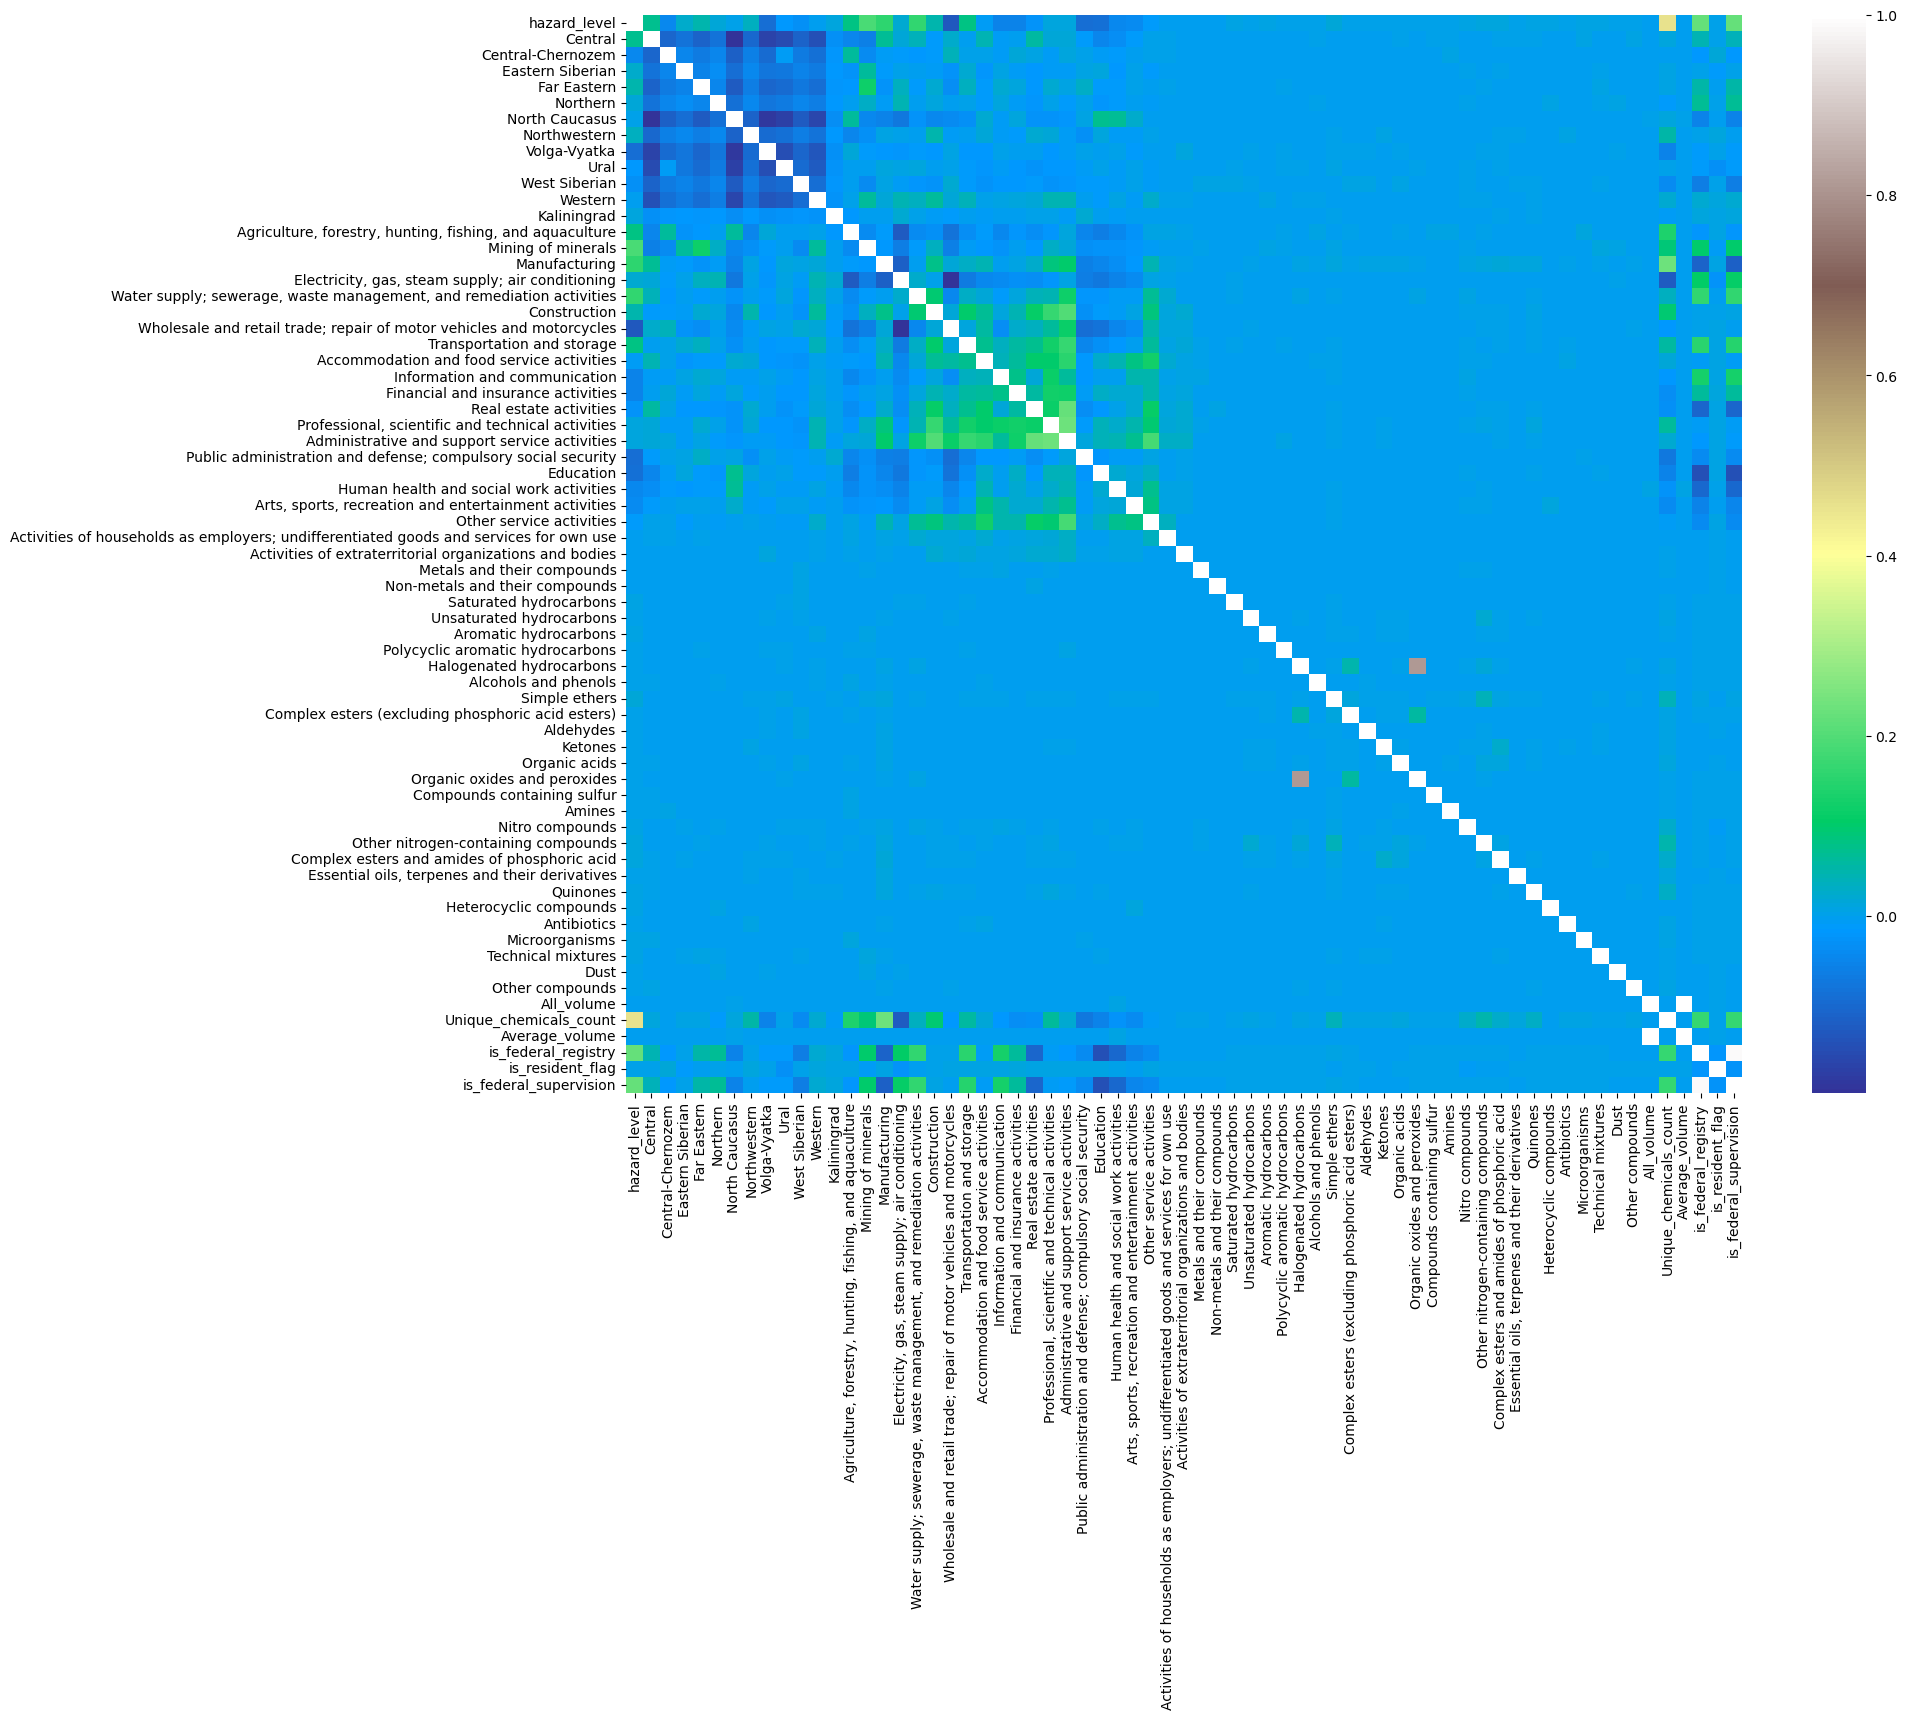

In [75]:
fig, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(cleaned_objects[needed_columns].corr(), cmap="terrain", ax=ax)
plt.savefig('heatmap.png')
plt.show()

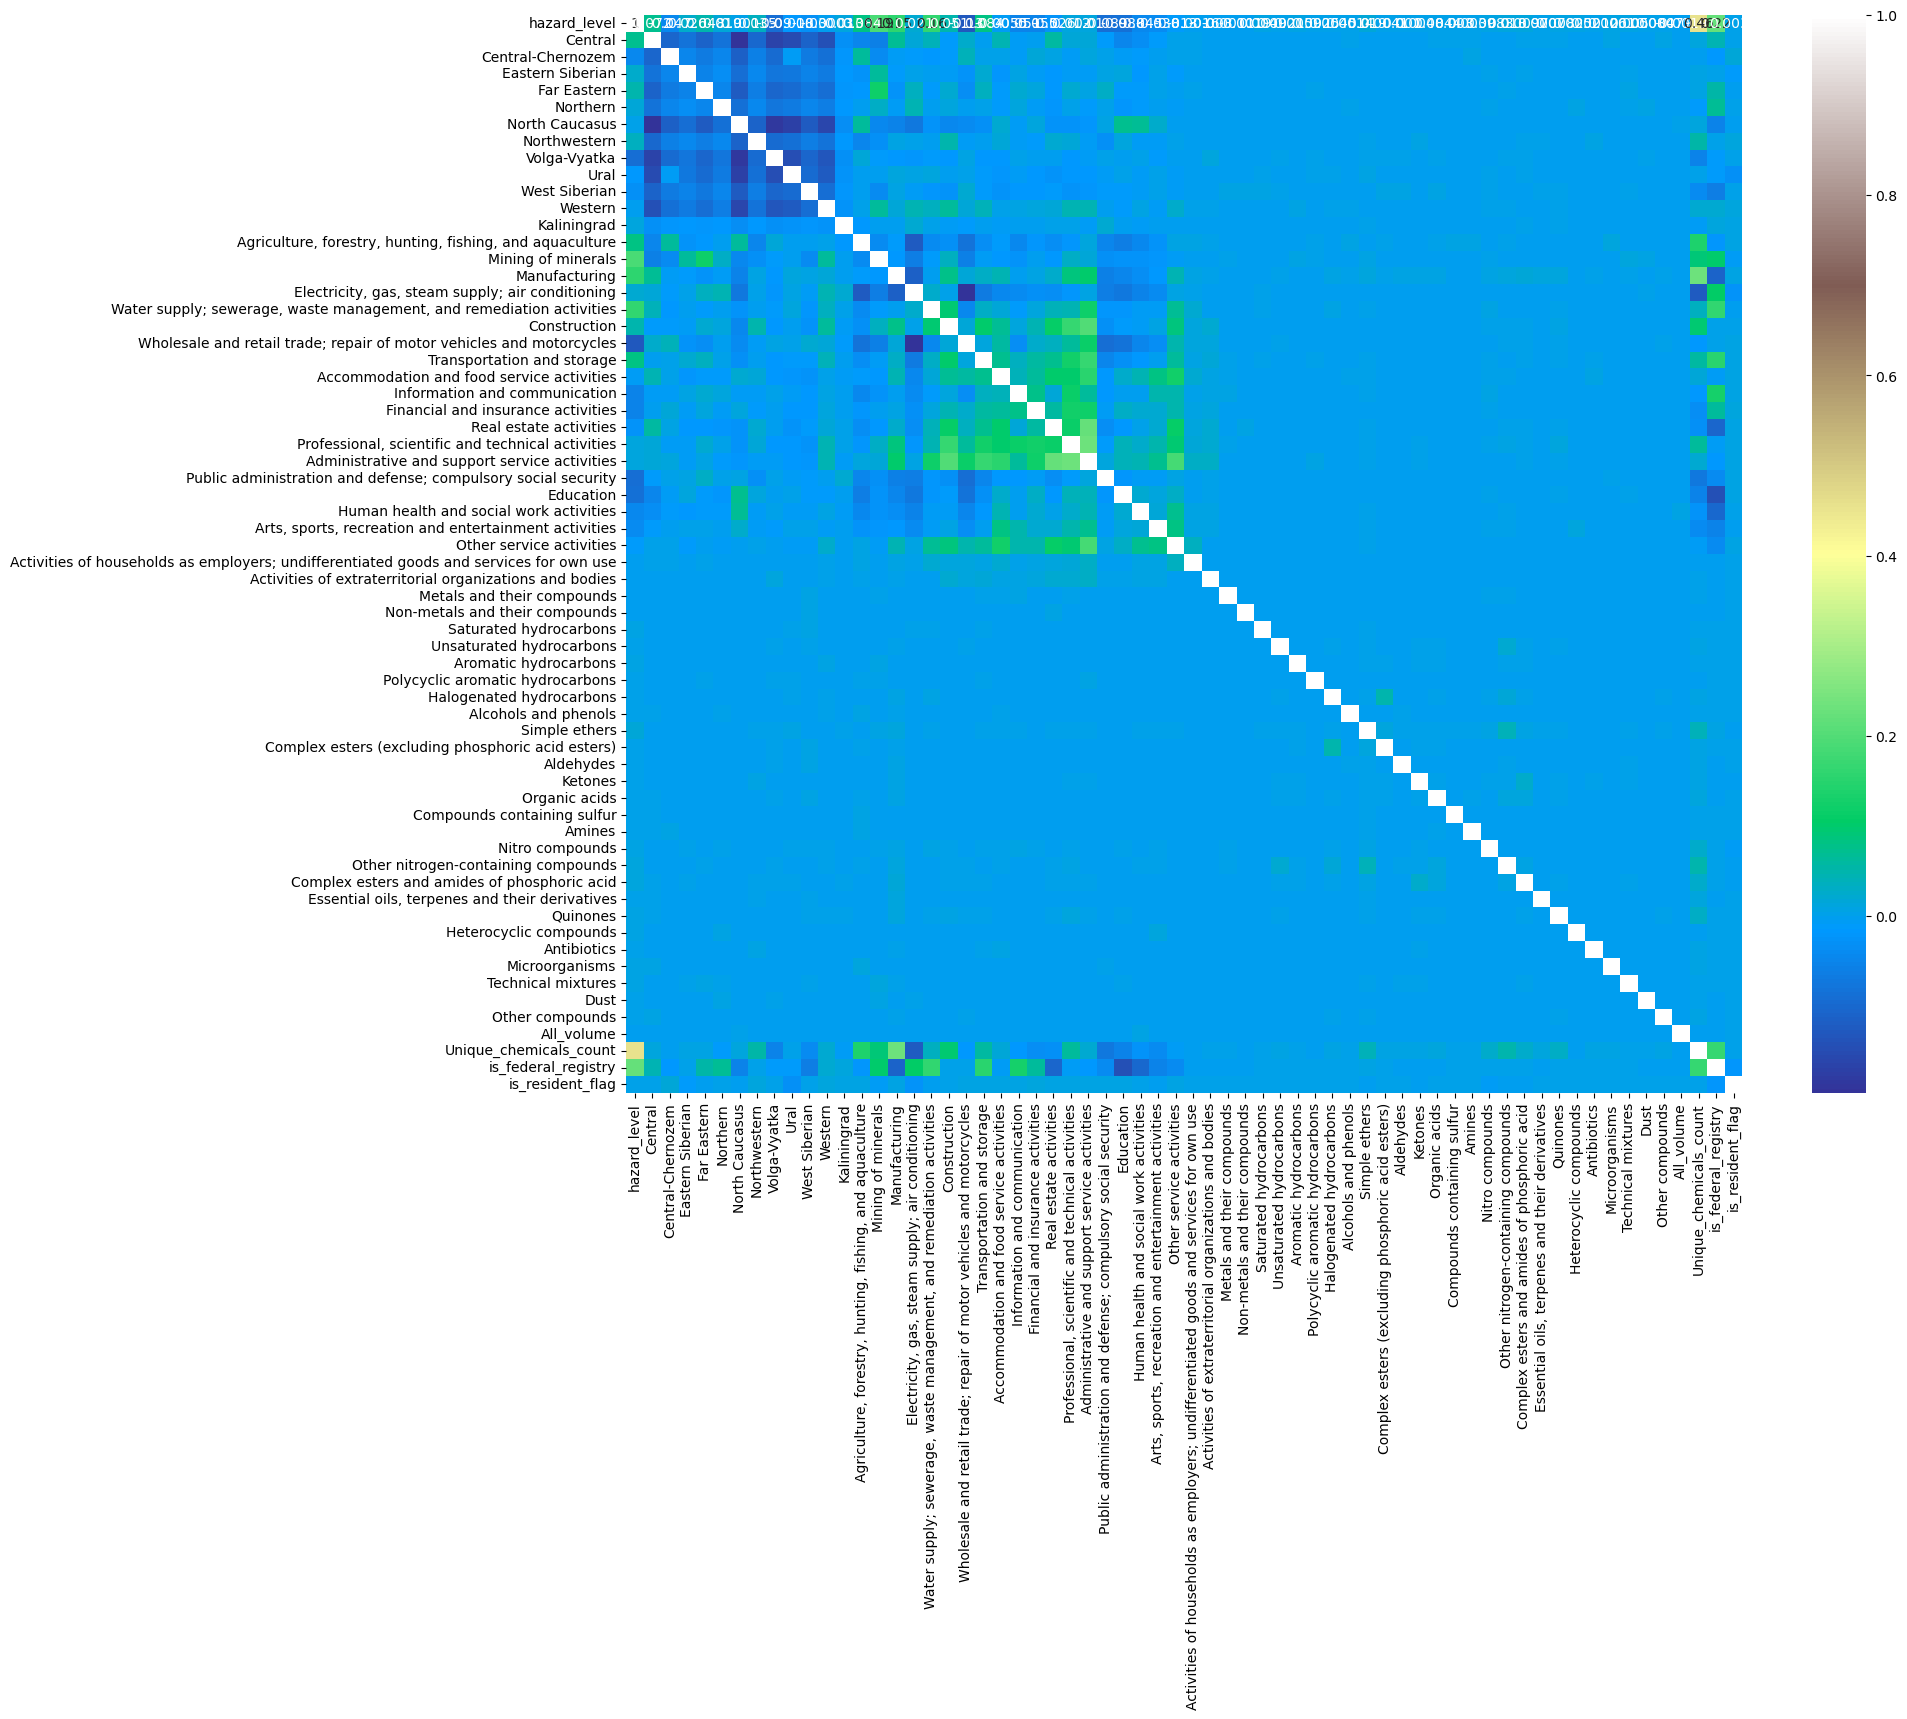

In [76]:
corr_matrix = cleaned_objects[needed_columns].corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
cleaned_objects_reduced = cleaned_objects[needed_columns].drop(to_drop, axis=1)

fig, ax = plt.subplots(figsize=(18, 14))

sns.heatmap(cleaned_objects_reduced.corr(), cmap="terrain", annot=True, ax=ax)

#plt.savefig('heatmap.png')
plt.show()


In [77]:
cleaned_objects = cleaned_objects.drop(to_drop, axis=1)

In [78]:
columns_to_exclude = ['onv_id', 'name', 'request_organization_full_name', 'latitude', 'longitude', 'hazard_level']

numerical_columns = [col for col in cleaned_objects.columns if col not in columns_to_exclude]
ordinal_columns = ['hazard_level']  
needed_columns = ordinal_columns + numerical_columns 

All the objects that are not located outside the Russian borders (possible outliers) will be omitted or ignored during visualisation in order to maintain the integrity of my data - Ecological Risk Zones are explored onli within Russia using resident and non-resident objects NVOS operating on the territory. 

Downloaded shapefile of Russian Borders is used and applied for filtering.

In [79]:
russia_boundaries_file = 'russia_administrative_boundaries_national_polygon.geojson/russia_administrative_boundaries_national_polygon.geojson'
russia_boundaries = gpd.read_file(russia_boundaries_file)

gdf = gpd.GeoDataFrame(cleaned_objects, geometry=gpd.points_from_xy(cleaned_objects.longitude, cleaned_objects.latitude))

inside_russia = gpd.sjoin(gdf, russia_boundaries, op='within')
inside_russia = inside_russia.drop(columns='index_right')
filtered_cleaned_objects = inside_russia.drop(columns='geometry')
filtered_cleaned_objects.reset_index(drop=True, inplace=True)
print("Shape of filtered DataFrame:", filtered_cleaned_objects.shape)


/Users/stacey/anaconda3/envs/diploma/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/60/j9xf7bjd7bx5xd574v9kbf_w0000gn/T/ipykernel_26154/655842162.py:16: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  inside_russia = gpd.sjoin(gdf, russia_boundaries, op='within')


Shape of filtered DataFrame: (366835, 74)


/var/folders/60/j9xf7bjd7bx5xd574v9kbf_w0000gn/T/ipykernel_26154/3208844643.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


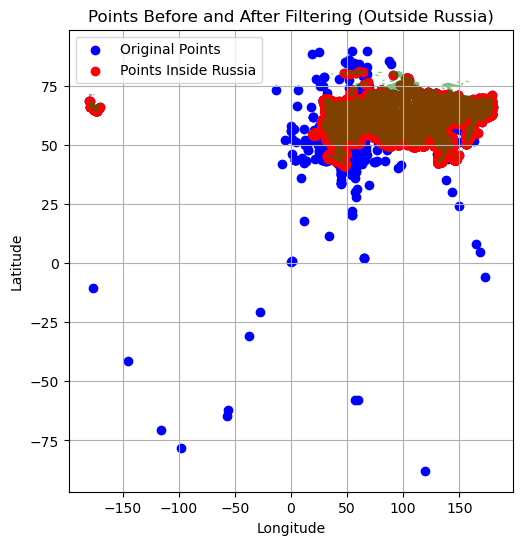

In [80]:
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_objects.longitude, cleaned_objects.latitude, color='blue', label='Original Points')
plt.scatter(filtered_cleaned_objects.longitude, filtered_cleaned_objects.latitude, color='red', label='Points Inside Russia')
russia_boundaries.plot(ax=plt.gca(), color='green', alpha=0.5, label='Russia Boundaries')

plt.title('Points Before and After Filtering (Outside Russia)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [81]:
cleaned_objects = filtered_cleaned_objects

In [82]:
cleaned_objects.to_csv('cleaned_objects.csv')

Scaling numerical and categorical data are two distinct processes: I use classic (x-mean) / std for numerical features and MinMax for ordinal columns:

In [83]:
numeric_transformer = StandardScaler()  # (X - mean) / std)
ordinal_transformer = MinMaxScaler()  # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) then X_scaled = X_std * (max - min) + min

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),  
        ('ord', ordinal_transformer, ordinal_columns)  
    ],
    remainder='passthrough'  # keep the columns(like 'name' or 'latitude') not specified in transformers unchanged
)

cleaned_objects_num = preprocessor.fit_transform(cleaned_objects[needed_columns])


In [84]:
features = PCA(n_components=2, random_state=12).fit_transform(cleaned_objects_num) 


In [85]:
city = "Moscow"
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Москва, Центральный федеральный округ, Россия
[lat, long]: [55.7505412, 37.6174782]


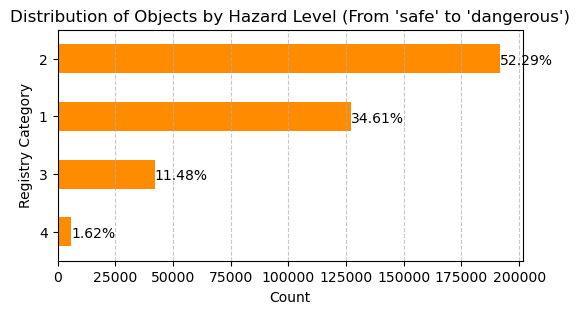

In [90]:
x = "hazard_level"

ax = cleaned_objects[x].value_counts().sort_values().plot(kind="barh", figsize=(6, 3), color='darkorange')

totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width() + 5, i.get_y() + 0.15, 
             f'{round((i.get_width() / total) * 100, 2)}%', 
             fontsize=10, color='black')

ax.grid(axis="x", linestyle='--', alpha=0.7)

plt.title("Distribution of Objects by Hazard Level (From 'safe' to 'dangerous')", fontsize=12)
plt.xlabel("Count", fontsize=10)
plt.ylabel("Registry Category", fontsize=10)

plt.show()


## 2.2 Clustering Methods

Analyzing data associated with geographical coordinates or spatial attributes requires a nuanced approach. Different methodologies yield diverse insights, all of which are crucial for comprehensive research. In my case, I aim to explore various techniques for analyzing such data, which includes both attributes and coordinates.

#### *Multivariate Clustering Using Classic Methods:*
I will begin by examining clustering algorithms solely based on observation attributes. I'll apply classical multivariate clustering methods, considering all attributes and utilizing the Analytical Base Table (ABT) created earlier. Techniques like K-means, BIRCH, Dirichlet Process Bayesian Gaussian Mixture clustering will be employed to identify clusters based on the collective attributes of the data points. This approach provides a holistic view by considering all available information for objects NVOS.


#### *Analysis with Coordinate-based Algorithms:*
The second approach aims to uncover spatial patterns and identify ecological risk zones. The algorithms I'll utilize include CLARA, HDBSCAN and Self-Organizing Maps. These algorithms are adept at identifying clusters of varying densities, making them suitable for analyzing spatial data with many entries.


#### *Integration and Advanced Analysis:*
In the final stage, I will integrate the insights obtained from both approaches to conduct advanced analysis. By combining ideas from coordinate-based algorithms and multivariate clustering, I aim to explore novel methodologies such as SKATER, AZP, Arisel, and Max-P. These methods offer unique perspectives, allowing for the identification of distinctive cluster patterns and the imposition of constraints on clusters.

#### *Additional Analysis Techniques:*
Moreover, techniques like Build Balanced Zones and Collocation Analysis will be emmployed to further enhance the study. These methods provide additional layers of understanding, facilitating a comprehensive exploration of spatial data.

#### *Comparative Evaluation:*
Throughout the analysis, I will systematically compare the results obtained from each group of techniques. By evaluating the performance of different clustering methods within each group, I aim to determine which approach is most suitable for my dataset. This comparative evaluation will provide valuable insights into the strengths and limitations of each technique, guiding the selection of the most effective methodology for analyzing spatial data.

### (A) Attribute-based Clusterization Methods (K-Means, Dirichlet Process BGM, BIRCH)

First, I need to choose the appropriate (or at least prudent) starting point regarding number of clusters. One of the most popular techniques is **'The Elbow Method'**.

  0%|          | 0/12 [00:00<?, ?it/s]

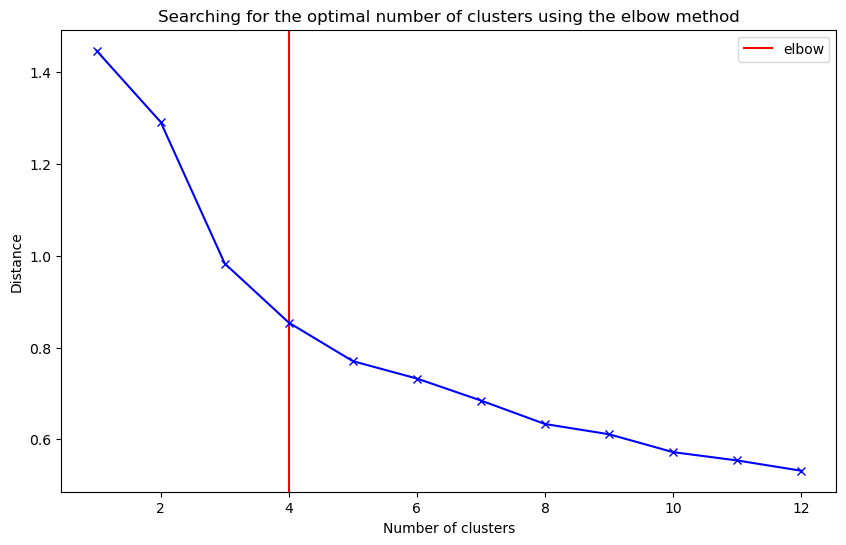

In [91]:
dict = defaultdict(list) 

for n in tqdm(range(1, 13), leave=False):
    kmeans = KMeans(n, n_init=10).fit(features) 
    distances = np.min(cdist(features, kmeans.cluster_centers_), axis=1) 
    mean_distance = np.mean(distances)  
    dict['distance'].append(mean_distance)  

clusters_range = range(1, 13)  

plt.figure(figsize=(10, 6)) 
plt.axvline(4, 0, 1, label='elbow', color='red')  
plt.plot(clusters_range, dict['distance'], 'bx-')  
plt.xlabel('Number of clusters') 
plt.ylabel('Distance') 
plt.title('Searching for the optimal number of clusters using the elbow method')
plt.legend()

plt.show()                                                                                                                      



Even though that the offered number of clusters is 4, one should be careful when it comes to 'smooth elbows'.

If the elbow method does not show a clear curvature, this usually means that the data does not have an explicit cluster structure. In such cases, it may be difficult to determine the optimal number of clusters, as the reduction of the sum of squares of distances within clusters (WCSS) occurs smoothly and without sudden changes.

This may indicate several things:
1. The data are evenly distributed and do not have strict groupings.
2. Clusters overlap and there is no clear boundary between them.

To handle the issue, I will look at the most curved and dubious points and explore the behaviour (adequacy of interpretation and three various metrics) of chosen attribute-based models for 3, 4 and 5 clusters, respectively. Then I will run all models with that number of clusters (not all models require it beforehand, though) and take the best performing and interpretable model to make interpret clusters and derive some interesting and valuable insights for further analysis.

#### K-Means with PCA

In [198]:
colors = ['#FFA07A', '#B0E0E6', '#97C1A9']

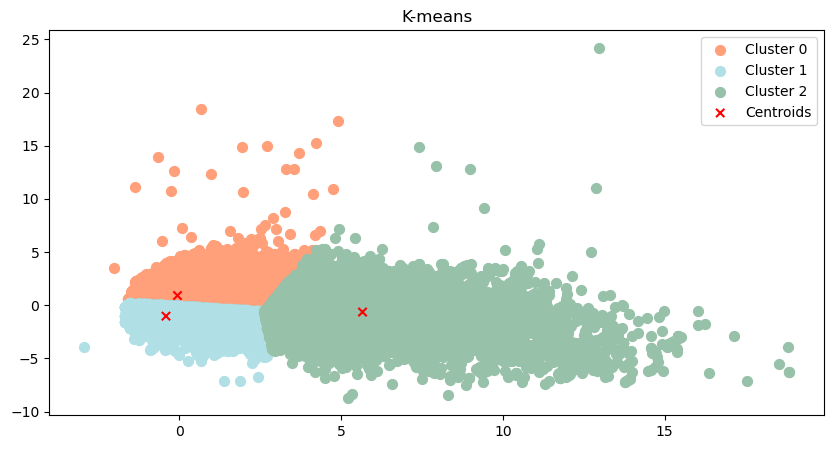

In [204]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(features)  
kmeans_labels = kmeans.predict(features) 

c_arr = np.array(list(map(lambda x: colors[x], list(kmeans_labels)))) 

plt.figure(figsize=(10,5)) 
plt.title('K-means') 

for i in range(n_clusters):
    plt.scatter(features[kmeans_labels == i, 0], features[kmeans_labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')

c_arr = np.array([[1, 0, 0] for i in range(n_clusters)]) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c=c_arr, marker='x', label='Centroids')
plt.legend()
plt.savefig('K-means.png')

#### Dirichlet Process BGM

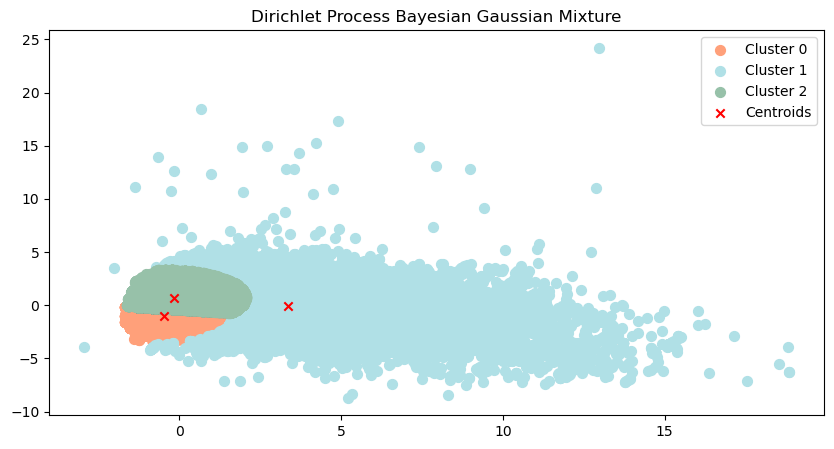

In [215]:
dpbgm = BayesianGaussianMixture(n_components=3, 
                                covariance_type='spherical', # Each component has its own single variance
                                weight_concentration_prior_type='dirichlet_process',
                                init_params='k-means++',
                                max_iter=1000, # more than enough to make it converge
                                random_state=42) # seed it

dpbgm.fit(features)

dpbgm_labels = dpbgm.predict(features)

plt.figure(figsize=(10, 5))
plt.title('Dirichlet Process Bayesian Gaussian Mixture')

for i, color in enumerate(colors):
    plt.scatter(features[dpbgm_labels == i, 0], features[dpbgm_labels == i, 1], s=50, c=[color], label=f'Cluster {i}')

plt.scatter(dpbgm.means_[:, 0], dpbgm.means_[:, 1], c='red', marker='x', label='Centroids')
plt.legend()
#plt.show()
plt.savefig('dpbgm.png')


#### BIRCH

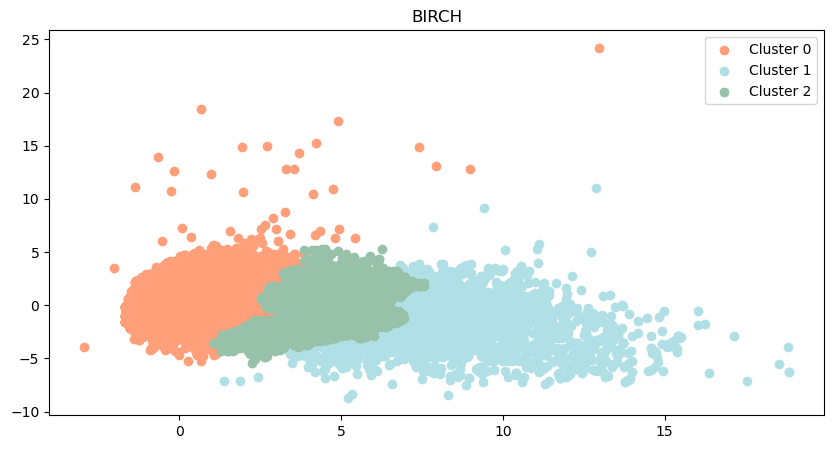

In [216]:
birch = Birch(threshold=0.05, n_clusters=3) #using SearchGrid method best threshold was chosen
birch.fit(features)
yhat = birch.predict(features)
clusters = unique(yhat)


# # Индекс Калински-Харабаса
# calinski_harabasz = calinski_harabasz_score(features, yhat)
# print(f'Индекс Калински-Харабаса: {calinski_harabasz:.2f}')

# # Индекс Дэвиса-Боулдина
# davies_bouldin = davies_bouldin_score(features, yhat)
# print(f'Индекс Дэвиса-Боулдина: {davies_bouldin:.2f}')

plt.figure(figsize=(10,5))
plt.title('BIRCH')

for cluster, color in zip(clusters, colors):
    row_ix = np.where(yhat == cluster)
    plt.scatter(features[row_ix, 0], features[row_ix, 1], color=color, label=f'Cluster {cluster}')

plt.legend()
#plt.show()
plt.savefig('birch1.png')
#205  0.90  0.05
#187  0.80  0.01
#106  0.93  0.10
#108  0.78  0.20
#66  0.46  0.30

In [209]:
#kmeans
cleaned_objects['cluster_label'] = kmeans.labels_
cluster_info = {}

for cluster in range(n_clusters):
    cluster_data = cleaned_objects[cleaned_objects['cluster_label'] == cluster]
    
    avg_volume = cluster_data['All_volume'].mean()
    avg_unique_chemicals = cluster_data['Unique_chemicals_count'].mean()
    
    # The top 3 types of activities, chemicals, and regions
    top_activities = cluster_data.iloc[:, 17:36].sum().sort_values(ascending=False).head(3)
    top_chemicals = cluster_data.iloc[:, 36:58].sum().sort_values(ascending=False).head(3)
    top_regions = cluster_data.iloc[:, 5:16].sum().sort_values(ascending=False).head(3)
    
    # The top 3 most polluting objects
    most_polluting = cluster_data[cluster_data['hazard_level'].isin([3, 4])].sort_values(by=['All_volume', 'hazard_level'], ascending=False).head(3)
    
    cluster_info[cluster] = {
        'average_volume': avg_volume,
        'average_unique_chemicals': avg_unique_chemicals,
        'top_activities': top_activities.index.tolist(),
        'top_chemicals': top_chemicals.index.tolist(),
        'top_regions': top_regions.index.tolist(),
        'most_polluting_objects': most_polluting[['onv_id', 'name', 'request_organization_full_name', 'All_volume', 'hazard_level']].to_dict(orient='records')
    }

for cluster, info in cluster_info.items():
    print(f"Cluster {cluster}:")
    print(f"Average Volume of Discharges: {info['average_volume']}")
    print(f"Average Number of Unique Chemicals: {info['average_unique_chemicals']}")
    print(f"Top 3 Types of Activities: {info['top_activities']}")
    print(f"Top 3 Types of Unique Chemicals Discharged: {info['top_chemicals']}")
    print(f"Top 3 Regions: {info['top_regions']}")
    print(f"Top 3 Most Polluting Objects: {info['most_polluting_objects']}\n")


Cluster 0:
Average Volume of Discharges: 1382372.0491784054
Average Number of Unique Chemicals: 12.642864275390881
Top 3 Types of Activities: ['Electricity, gas, steam supply; air conditioning', 'Wholesale and retail trade; repair of motor vehicles and motorcycles', 'Transportation and storage']
Top 3 Types of Unique Chemicals Discharged: ['Non-metals and their compounds', 'Saturated hydrocarbons', 'Complex esters (excluding phosphoric acid esters)']
Top 3 Regions: ['Central', 'Western', 'Ural']
Top 3 Most Polluting Objects: [{'onv_id': 424197, 'name': 'Сельскохозяйственный комплекс', 'request_organization_full_name': 'Акционерное общество "Нива"', 'All_volume': 244605166.11699453, 'hazard_level': 3}, {'onv_id': 308786, 'name': 'Производственная территория ООО "ЗМЗ "ТОР" (Площадка котельной и цеха металлообработки)', 'request_organization_full_name': 'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЗАБАЙКАЛЬСКИЙ МЕТАЛЛУРГИЧЕСКИЙ ЗАВОД" ТОР"', 'All_volume': 8465730.594284201, 'hazard_level': 

#### Cluster 2: Urban Commercial Risks
- **Average Volume of Discharges**: The moderate volume suggests that while individual objects may not be excessively polluting, their cumulative effect could pose significant urban environmental risks.
- **Average Number of Unique Chemicals**: A diverse chemical profile indicates a variety of commercial activities, each contributing differently to the urban ecological footprint.
- **Top Activities**: The dominance of administrative, trade, and transportation activities points to urban centers where commercial operations are concentrated. These activities are often associated with vehicular emissions and waste generation, which can lead to air and water quality issues.
- **Top Chemicals**: The prevalence of non-metals and hydrocarbons is characteristic of urban pollution, stemming from a mix of industrial emissions and transportation.
- **Top Regions**: The Western, Central, and North Caucasus regions may have densely populated urban areas where commercial activities are intense, leading to a higher potential for ecological risks.
- **Most Polluting Objects**: The identified objects, such as a meat processing plant, suggest that certain industries within urban areas could be significant sources of pollution, warranting targeted environmental regulations and interventions.

#### Cluster 0: Heavy Industrial Risks
- **Average Volume of Discharges**: The significantly higher volume indicates that objects in this cluster are major industrial polluters, likely contributing to large-scale environmental degradation.
- **Average Number of Unique Chemicals**: The complexity of the chemical profile suggests a wide range of industrial processes, each with its own set of ecological impacts.
- **Top Activities**: Energy supply and transportation are typically associated with heavy industries, which are known for their extensive use of natural resources and potential for significant pollution.
- **Top Chemicals**: The discharge of complex esters and other hydrocarbons points to chemical processing and manufacturing industries, which often have a broad and severe impact on the environment.
- **Top Regions**: The Central, Western, and Ural regions may host heavy industrial complexes, which are critical to the economy but also pose substantial ecological risks.
- **Most Polluting Objects**: Large-scale operations such as agricultural complexes and refineries are indicative of high-risk zones for ecological damage due to their scale of operations and the level of hazardous emissions.


#### Cluster 1: Agricultural and Trade-Related Risks
- **Average Volume of Discharges**: Comparable to Cluster 0 and 2, the volume is much lower but in an agricultural context could indicate substantial runoff and waste, impacting soil and water systems.
- **Average Number of Unique Chemicals**: A lower variety of chemicals suggests more homogeneity in the types of pollutants, possibly related to specific agricultural practices or localized trade activities.
- **Top Activities**: The presence of agriculture and trade indicates rural or peri-urban areas where land use and commercial activities could lead to habitat fragmentation and pollution.
- **Top Chemicals**: Sulfur compounds and metals are often associated with agricultural runoff and industrial waste, which can lead to long-term soil degradation and water contamination.
- **Top Regions**: The North Caucasus, Volga-Vyatka, and Ural regions may be experiencing environmental pressures from intensive agriculture and growing trade sectors.
- **Most Polluting Objects**: Facilities like small power plants and production units in these regions highlight the intersection of energy, agriculture, and trade as key areas for ecological risk assessment.

**Synthesizing the Analysis for Ecological Risk Zones**:
- **Cluster 2** This cluster is characterized by a diverse range of commercial activities, including trade and transportation, typically found in urban settings. The entities here are associated with significant volumes of discharges and a variety of chemicals, indicating potential risks to air and water quality in densely populated areas. The presence of administrative services suggests that these risks are managed within a regulatory framework, but the high average volume of discharges points to the need for stringent monitoring and mitigation strategies..
- **Cluster 0** Entities in this cluster are involved in energy production and heavy industry, which are known for their substantial environmental impacts. The extremely high average volume of discharges and the presence of complex chemical compounds highlight the ecological risks associated with these sectors. The regions represented suggest that these activities are spread across various industrial zones, necessitating focused environmental oversight and robust pollution control measures..
- **Cluster 1** This cluster encompasses a mix of manufacturing and agricultural activities, likely situated in regional areas. The lower average volume of discharges and fewer unique chemicals suggest more localized environmental impacts. However, the presence of sulfur compounds and metals indicates specific industrial processes that could pose ecological risks. The activities and regions imply that these risks are distributed across different landscapes, requiring tailored approaches to environmental management and protection..

This detailed analysis of clusters provides a nuanced understanding of the potential ecological risk zones - it underscores the need for differentiated environmental strategies that consider the specific types of activities, chemicals involved, and regional characteristics. By linking these clusters to ecological risk zones, your thesis can contribute to the development of targeted environmental policies and management practices that address the unique challenges presented by each cluster.

#### Comparison Results

In [89]:
# For computational reasons  
sample_indices = np.random.choice(features.shape[0], 100000, replace=False)
sample_features = features[sample_indices]

results = {}

for k in [3, 4, 5]:
    
    # K-Means
    kmeans = KMeans(n_clusters=k, n_init=10).fit(sample_features)
    kmeans_labels = kmeans.predict(sample_features)
    kmeans_silhouette = silhouette_score(sample_features, kmeans_labels)
    kmeans_calinski = calinski_harabasz_score(sample_features, kmeans_labels)
    kmeans_davies = davies_bouldin_score(sample_features, kmeans_labels)
    
    # DPBGM
    dpbgm = BayesianGaussianMixture(n_components=k,
                                    covariance_type='spherical', # was chosen using SearchGrid method
                                    weight_concentration_prior_type='dirichlet_process', # chosen as there is no known # of clusters beforehand
                                    # weight_concentration_prior=1e+1,
                                    init_params='k-means++',
                                    max_iter=1000, # More than enough iterations to make it converge
                                    random_state=42) # seed it
    dpbgm.fit(sample_features)
    dpbgm_labels = dpbgm.predict(sample_features)
    dpbgm_silhouette = silhouette_score(sample_features, dpbgm_labels)
    dpbgm_calinski = calinski_harabasz_score(sample_features, dpbgm_labels)
    dpbgm_davies = davies_bouldin_score(sample_features, dpbgm_labels)
    
    # Birch
    birch = Birch(threshold=0.05, n_clusters=k)
    birch.fit(sample_features)
    birch_labels = birch.predict(sample_features)
    birch_silhouette = silhouette_score(sample_features, birch_labels)
    birch_calinski = calinski_harabasz_score(sample_features, birch_labels)
    birch_davies = davies_bouldin_score(sample_features, birch_labels)
    
    results[k] = {
        'kmeans': (kmeans_silhouette, kmeans_calinski, kmeans_davies),
        'dpbgm': (dpbgm_silhouette, dpbgm_calinski, dpbgm_davies),
        'birch': (birch_silhouette, birch_calinski, birch_davies)
    }

for k, metrics in results.items():
    print(f"Results for {k} clusters:")
    print(f"K-Means Silhouette Coefficient: {metrics['kmeans'][0]:.2f}")
    print(f"K-Means Calinski-Harabasz Index: {metrics['kmeans'][1]:.2f}")
    print(f"K-Means Davies-Bouldin Index: {metrics['kmeans'][2]:.2f}\n")
    print(f"DPBGM Silhouette Coefficient: {metrics['dpbgm'][0]:.2f}")
    print(f"DPBGM Calinski-Harabasz Index: {metrics['dpbgm'][1]:.2f}")
    print(f"DPBGM Davies-Bouldin Index: {metrics['dpbgm'][2]:.2f}\n")
    print(f"Birch Silhouette Coefficient: {metrics['birch'][0]:.2f}")
    print(f"Birch Calinski-Harabasz Index: {metrics['birch'][1]:.2f}")
    print(f"Birch Davies-Bouldin Index: {metrics['birch'][2]:.2f}\n")


/Users/stacey/anaconda3/envs/diploma/lib/python3.11/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Results for 3 clusters:
K-Means Silhouette Coefficient: 0.40
K-Means Calinski-Harabasz Index: 74667.12
K-Means Davies-Bouldin Index: 0.82

DPBGM Silhouette Coefficient: 0.40
DPBGM Calinski-Harabasz Index: 60519.19
DPBGM Davies-Bouldin Index: 0.88

Birch Silhouette Coefficient: 0.54
Birch Calinski-Harabasz Index: 32029.58
Birch Davies-Bouldin Index: 0.93

Results for 4 clusters:
K-Means Silhouette Coefficient: 0.33
K-Means Calinski-Harabasz Index: 68843.89
K-Means Davies-Bouldin Index: 0.92

DPBGM Silhouette Coefficient: 0.31
DPBGM Calinski-Harabasz Index: 50412.99
DPBGM Davies-Bouldin Index: 0.86

Birch Silhouette Coefficient: 0.48
Birch Calinski-Harabasz Index: 23997.15
Birch Davies-Bouldin Index: 0.82

Results for 5 clusters:
K-Means Silhouette Coefficient: 0.36
K-Means Calinski-Harabasz Index: 71519.58
K-Means Davies-Bouldin Index: 0.82

DPBGM Silhouette Coefficient: 0.33
DPBGM Calinski-Harabasz Index: 60539.63
DPBGM Davies-Bouldin Index: 0.89

Birch Silhouette Coefficient: 0.36
Bir

In [117]:
results = {}

for k in [3, 4, 5]:
    
    # K-Means
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(features)
    kmeans_labels = kmeans.predict(features)
    kmeans_silhouette = silhouette_score(features, kmeans_labels)
    kmeans_calinski = calinski_harabasz_score(features, kmeans_labels)
    kmeans_davies = davies_bouldin_score(features, kmeans_labels)
    
    # DPBGM
    dpbgm = BayesianGaussianMixture(n_components=k,
                                    covariance_type='spherical',
                                    weight_concentration_prior_type='dirichlet_process',
                                    init_params='k-means++',
                                    max_iter=1000,
                                    random_state=42)
    dpbgm.fit(features)
    dpbgm_labels = dpbgm.predict(features)
    dpbgm_silhouette = silhouette_score(features, dpbgm_labels)
    dpbgm_calinski = calinski_harabasz_score(features, dpbgm_labels)
    dpbgm_davies = davies_bouldin_score(features, dpbgm_labels)
    
    # Birch
    # Birch does not have a random_state parameter, so results may vary
    birch = Birch(threshold=0.05, n_clusters=k)
    birch.fit(features)
    birch_labels = birch.predict(features)
    birch_silhouette = silhouette_score(features, birch_labels)
    birch_calinski = calinski_harabasz_score(features, birch_labels)
    birch_davies = davies_bouldin_score(features, birch_labels)
    
    results[k] = {
        'kmeans': (kmeans_silhouette, kmeans_calinski, kmeans_davies),
        'dpbgm': (dpbgm_silhouette, dpbgm_calinski, dpbgm_davies),
        'birch': (birch_silhouette, birch_calinski, birch_davies)
    }

for k, metrics in results.items():
    print(f"Results for {k} clusters:")
    print(f"K-Means Silhouette Coefficient: {metrics['kmeans'][0]:.2f}")
    print(f"K-Means Calinski-Harabasz Index: {metrics['kmeans'][1]:.2f}")
    print(f"K-Means Davies-Bouldin Index: {metrics['kmeans'][2]:.2f}\n")
    print(f"DPBGM Silhouette Coefficient: {metrics['dpbgm'][0]:.2f}")
    print(f"DPBGM Calinski-Harabasz Index: {metrics['dpbgm'][1]:.2f}")
    print(f"DPBGM Davies-Bouldin Index: {metrics['dpbgm'][2]:.2f}\n")
    print(f"Birch Silhouette Coefficient: {metrics['birch'][0]:.2f}")
    print(f"Birch Calinski-Harabasz Index: {metrics['birch'][1]:.2f}")
    print(f"Birch Davies-Bouldin Index: {metrics['birch'][2]:.2f}\n")


Results for 3 clusters:
K-Means Silhouette Coefficient: 0.39
K-Means Calinski-Harabasz Index: 269192.32
K-Means Davies-Bouldin Index: 0.82

DPBGM Silhouette Coefficient: 0.40
DPBGM Calinski-Harabasz Index: 218477.46
DPBGM Davies-Bouldin Index: 0.88

Birch Silhouette Coefficient: 0.36
Birch Calinski-Harabasz Index: 205467.65
Birch Davies-Bouldin Index: 0.90

Results for 4 clusters:
K-Means Silhouette Coefficient: 0.33
K-Means Calinski-Harabasz Index: 247481.25
K-Means Davies-Bouldin Index: 0.92

DPBGM Silhouette Coefficient: 0.31
DPBGM Calinski-Harabasz Index: 167512.97
DPBGM Davies-Bouldin Index: 0.83

Birch Silhouette Coefficient: 0.35
Birch Calinski-Harabasz Index: 147526.07
Birch Davies-Bouldin Index: 1.09

Results for 5 clusters:
K-Means Silhouette Coefficient: 0.36
K-Means Calinski-Harabasz Index: 256422.59
K-Means Davies-Bouldin Index: 0.82

DPBGM Silhouette Coefficient: 0.33
DPBGM Calinski-Harabasz Index: 214404.29
DPBGM Davies-Bouldin Index: 0.90

Birch Silhouette Coefficient: 

**Silhouette Coefficient:** Values range from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate.

**Calinski-Harabasz Index:** A higher value generally indicates that the clusters are dense and well separated, which is desirable.

**Davies-Bouldin Index:** The lower the value, the better, as it indicates that the clusters are farther apart and less overlapping.

Generally, the number of clusters depends on several factors, including the interpretability of clusters and the clustering quality metric. 

**For 3 Clusters:**
K-Means has a Silhouette Coefficient of 0.39, indicating moderate separation between clusters. The Calinski-Harabasz Index is quite high at 269192.32, suggesting well-defined clusters, and the Davies-Bouldin Index is 0.82, pointing to decent cluster separation.
DPBGM also has a Silhouette Coefficient of 0.40, but a lower Calinski-Harabasz Index of 218477.46, indicating less distinct clusters compared to K-Means. The Davies-Bouldin Index is 0.88, slightly higher than K-Means, suggesting less separation.
Birch has the lowest Silhouette Coefficient of 0.36, which implies less tighter clusters. Its Calinski-Harabasz Index is also the lowest at 205467.65, potentially indicating that the clusters are not as well-separated as those formed by K-Means, with a Davies-Bouldin Index of 0.90.

**For 4 Clusters:**
K-Means sees a decrease in the Silhouette Coefficient to 0.33 and the Calinski-Harabasz Index to 247481.25, suggesting that the addition of another cluster has led to less cohesion and separation. The Davies-Bouldin Index increases to 0.92, indicating worse separation.

DPBGM also shows a decrease in both the Silhouette Coefficient to 0.31 and the Calinski-Harabasz Index to 167512.97, which suggests that the clusters are becoming less distinct and cohesive with more clusters. The Davies-Bouldin Index of 0.83 is slightly better than K-Means, indicating better separation than K-Means for 4 clusters.

Birch has a Silhouette Coefficient of 0.35 and the lowest Calinski-Harabasz Index of 147526.07, suggesting that the clusters are not very distinct or dense. The Davies-Bouldin Index of 1.09 is the highest, indicating the poorest separation among the three methods.

**For 5 Clusters:**
K-Means improves slightly in the Calinski-Harabasz Index to 256422.59, suggesting better-defined clusters compared to 4 clusters, but the Silhouette Coefficient decreases to 0.36.

DPBGM has a Silhouette Coefficient of 0.33 and a Calinski-Harabasz Index of 214404.29, both of which suggest that the quality of the clusters is not improving with more clusters. The Davies-Bouldin Index of 0.90 is higher than for 4 clusters, indicating less separation.

Birch shows a slight increase in the Silhouette Coefficient to 0.37 but a decrease in the Calinski-Harabasz Index to 166079.86, suggesting that the clusters are not as well-separated as with fewer clusters. The Davies-Bouldin Index of 0.98 is also high, indicating poor separation.

*In conclusion, K-Means has the best overall scores for 3 clusters, suggesting it is the best choice for this particular dataset. It provides a balance between cluster cohesion (as indicated by the Silhouette Coefficient) and separation (as indicated by the Calinski-Harabasz and Davies-Bouldin indices). Birch, while having a reasonable Silhouette Coefficient, does not perform as well on the other two indices, suggesting that it may not be as effective for this dataset. Therefore, starting with 3 clusters would be a good approach for further analysis and interpretation.*

#### Given the importance of both cluster tightness and separation for identifying similar objetcs for further analysis of risk zones, **3 clusters** seem to be a good starting point, especially considering the results from DPBGM and K-Means. 

However, for a more detailed division, if 5 clusters provide a more informative division of risk zones, then it is worth considering these options, despite the slightly worse metrics.

By analyzing the characteristics and distribution of these clusters, I aim to establish a link between the clustered objects and potential ecological risk zones.

### (B) Location-based Clusterization Methods (HDBSCAN, CLARA, SOM)

Complete Spatial Randomness (CSR) implies a completely random spatial distribution of points, with no discernible pattern or clustering. A Kernel Density Estimation (KDE) plot showing varying intensity suggests that the spatial distribution of your data is not entirely random, indicating deviations from CSR.

/Users/stacey/anaconda3/envs/diploma/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/stacey/anaconda3/envs/diploma/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


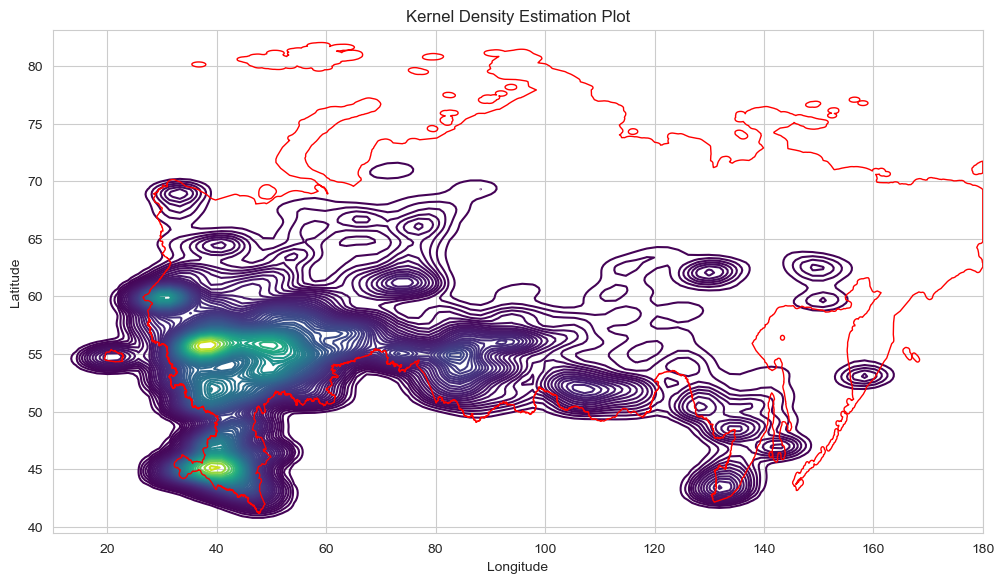

In [129]:
russia_boundaries = gpd.read_file('russia_administrative_boundaries_national_polygon.geojson/russia_administrative_boundaries_national_polygon.geojson')

sns.set_style("whitegrid")

plt.figure(figsize=(12, 8))

sns.kdeplot(
    data=cleaned_objects,
    x="longitude",
    y="latitude",
    #fill=True,
    cmap="viridis",
    levels=60,  #  the number of contour levels
    thresh=0,  # the minimum threshold for including contour lines
)

russia_boundaries.boundary.plot(ax=plt.gca(), color='red', linewidth=1)

plt.title("Kernel Density Estimation Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.xlim(10, 180)

plt.show()


#### HDBSCAN

In [253]:
hdb = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_epsilon=0.005, min_samples=100,  metric='haversine')

points = cleaned_objects[["latitude", "longitude"]]
rads = np.radians(points)

hdb.fit(rads)
labels = hdb.labels_
cleaned_objects['cluster'] = labels

map_ = folium.Map(location=location, tiles="cartodb positron", zoom_start=5)

num_clusters = len(set(labels)) 
colors = sns.color_palette('pastel', num_clusters).as_hex()

# Cluster number to color
cluster_colors = {k: colors[k] for k in range(num_clusters)}

for idx, row in cleaned_objects.iterrows():
    point_color = cluster_colors.get(row['cluster'], '#808080')
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5,
                        color=point_color,
                        fill=True).add_to(map_)

map_.save('hdbscan2.html')



In [254]:
hdb_labels = cleaned_objects['cluster']

# Silhouette Coefficient
hdb_silhouette = silhouette_score(rads, hdb_labels, metric='haversine')
print(f"HDBSCAN Silhouette Coefficient: {hdb_silhouette}")

# Calinski-Harabasz Index
hdb_calinski = calinski_harabasz_score(rads, hdb_labels)
print(f"HDBSCAN Calinski-Harabasz Index: {hdb_calinski}")

# Davies-Bouldin Index
hdb_davies = davies_bouldin_score(rads, hdb_labels)
print(f"HDBSCAN Davies-Bouldin Index: {hdb_davies}")


HDBSCAN Silhouette Coefficient: -0.17138498556056697
HDBSCAN Calinski-Harabasz Index: 9364.50565024515
HDBSCAN Davies-Bouldin Index: 2.4435825498682253


#### CLARA

In [255]:
from sklearn_extra.cluster import CLARA

clara = CLARA(n_clusters=19, metric='haversine', max_iter=500)

clara.fit(rads)

num_clusters = clara.n_clusters
colors = sns.color_palette('pastel', num_clusters).as_hex()
cluster_colors = {k: colors[k] for k in range(num_clusters)}

first_medoid_index = clara.medoid_indices_[0]
location = cleaned_objects.iloc[first_medoid_index][['latitude', 'longitude']].values.tolist()
map_ = folium.Map(location=location, tiles="cartodb positron", zoom_start=5)

for idx, row in cleaned_objects.iterrows():
    point_color = cluster_colors[clara.labels_[idx]]
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5,
                        color=point_color,
                        fill=True).add_to(map_)

for medoid_index in clara.medoid_indices_:
    medoid = cleaned_objects.iloc[medoid_index]
    folium.Marker(location=[medoid['latitude'], medoid['longitude']],
                  popup='Centroid',
                  draggable=False,
                  icon=folium.Icon(color="black")).add_to(map_)

map_.save('clara.html')

In [256]:
clara_labels = clara.labels_

# Silhouette Coefficient
clara_silhouette = silhouette_score(rads, clara_labels, metric='haversine')
print(f"CLARA Silhouette Coefficient: {clara_silhouette}")

# Calinski-Harabasz Index
clara_calinski = calinski_harabasz_score(rads, clara_labels)
print(f"CLARA Calinski-Harabasz Index: {clara_calinski}")

# Davies-Bouldin Index
clara_davies = davies_bouldin_score(rads, clara_labels)
print(f"CLARA Davies-Bouldin Index: {clara_davies}")

CLARA Silhouette Coefficient: 0.39752516751364336
CLARA Calinski-Harabasz Index: 509606.7028547692
CLARA Davies-Bouldin Index: 1.0868614228701476


#### Self Organizing Maps

In [258]:
X = cleaned_objects[["latitude", "longitude"]]
map_shape = (4, 4)

scaler = preprocessing.StandardScaler()
X_preprocessed = scaler.fit_transform(X.values)

model = minisom.MiniSom(x=map_shape[0], y=map_shape[1], input_len=X.shape[1])
model.train_batch(X_preprocessed, num_iteration=100, verbose=False)

dtf_X = X.copy()
dtf_X["cluster"] = np.ravel_multi_index(np.array([model.winner(x) for x in X_preprocessed]).T, dims=map_shape)

# Find real centroids (prototypes)
prototypes = np.array([model.get_weights()[x][y] for x in range(map_shape[0]) for y in range(map_shape[1])])
closest, _ = scipy.cluster.vq.vq(prototypes, X_preprocessed)

# Mark the closest prototypes
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

cleaned_objects[["cluster", "centroids"]] = dtf_X[["cluster", "centroids"]]

k = cleaned_objects["cluster"].nunique()


/var/folders/60/j9xf7bjd7bx5xd574v9kbf_w0000gn/T/ipykernel_17813/134034671.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dtf_X["centroids"].iloc[i] = 1
/var/folders/60/j9xf7bjd7bx5xd574v9kbf_w0000gn/T/ipykernel_17813/134034671.py:20: 

In [251]:
map_ = folium.Map(location=location, tiles="cartodb positron", zoom_start=5)

num_clusters = cleaned_objects['cluster'].nunique()
colors = sns.color_palette('pastel', num_clusters).as_hex()

cluster_colors = {k: colors[k] for k in range(num_clusters)}

for idx, row in cleaned_objects.iterrows():
    point_color = cluster_colors[row['cluster']]
    
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5,
                        color=point_color,
                        fill=True).add_to(map_)

for idx, row in cleaned_objects[cleaned_objects['centroids'] == 1].iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup='Centroid',
                  draggable=False,
                  icon=folium.Icon(color="black")).add_to(map_)

map_.save('som.html')


In [259]:
minisom_labels = dtf_X['cluster']

# Silhouette Coefficient
minisom_silhouette = silhouette_score(X_preprocessed, minisom_labels)
print(f"MiniSom Silhouette Coefficient: {minisom_silhouette}")

# Calinski-Harabasz Index
minisom_calinski = calinski_harabasz_score(X_preprocessed, minisom_labels)
print(f"MiniSom Calinski-Harabasz Index: {minisom_calinski}")

# Davies-Bouldin Index
minisom_davies = davies_bouldin_score(X_preprocessed, minisom_labels)
print(f"MiniSom Davies-Bouldin Index: {minisom_davies}")


MiniSom Silhouette Coefficient: 0.21597571376177685
MiniSom Calinski-Harabasz Index: 109078.5436908533
MiniSom Davies-Bouldin Index: 0.9795909604603749


#### Comparison Results

### (C) Hybrid Models: **Spatially Constrained** Multivariate Clustering Methods (SKATER, AZP, Arisel, Max-P)

Check for Minnimum Spanning Trees Algos!

In [151]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

# Define the spatial penalty function
def spatial_penalty(cluster_centers, data_points, penalty_weight):
    # Calculate the Euclidean distance between each point and its cluster center
    distances = cdist(data_points, cluster_centers, 'euclidean')
    # Find the minimum distance (closest cluster center) for each point
    min_distances = np.min(distances, axis=1)
    # Calculate the penalty as the weighted sum of the distances
    penalty = penalty_weight * np.sum(min_distances)
    return penalty

# Modify the KMeans algorithm to include the spatial penalty
class SpatialPenaltyKMeans(KMeans):
    def _e_step(self, X):
        # Perform the regular KMeans E-step
        super()._e_step(X)
        # Calculate the spatial penalty
        penalty = spatial_penalty(self.cluster_centers_, X, penalty_weight)
        # Apply the spatial penalty to the cluster centers
        self.cluster_centers_ -= penalty

# Assuming 'features' is your PCA reduced data and 'cleaned_objects' contains the original latitude and longitude
penalty_weight = 0.8  # Define the penalty weight based on your domain knowledge
spatial_penalty_kmeans = SpatialPenaltyKMeans(n_clusters=19, n_init=10)
spatial_penalty_kmeans.fit(features)

# Predict the clusters
clusters = spatial_penalty_kmeans.predict(features)

# Visualization code (integrate this with the visualization code you provided earlier)
# ...



In [152]:
import folium
import seaborn as sns

# Assuming 'cleaned_objects' DataFrame has 'latitude' and 'longitude' columns
# and 'clusters' contains the cluster labels for each observation

# Initialize the map centered around the average coordinates
map_ = folium.Map(location=[cleaned_objects['latitude'].mean(), cleaned_objects['longitude'].mean()], tiles="cartodb positron", zoom_start=5)

# Generate a color palette with a unique color for each cluster
num_clusters = len(np.unique(clusters))
colors = sns.color_palette('pastel', num_clusters).as_hex()

# Add points to the map
for idx, row in cleaned_objects.iterrows():
    point_color = colors[clusters[idx]]
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5,
                        color=point_color,
                        fill=True).add_to(map_)

# Add centroids to the map
# for center_coords in spatial_penalty_kmeans.cluster_centers_:
#     # Transform the PCA components back to the original latitude and longitude
#     # This step assumes you have a way to inverse transform the PCA components
#     # If not, you'll need to adjust this part to correctly map the centroids
#     original_coords = pca.inverse_transform(center_coords)
#     folium.Marker(location=[original_coords[0], original_coords[1]],
#                   icon=folium.Icon(color="black")).add_to(map_)

# Save the map to an HTML file
map_.save('spatial_penalty_kmeans_map.html')


https://geoffboeing.com/2016/11/osmnx-python-street-networks/
for images and geo visualisation 

# 3. Conclusions

KeyboardInterrupt: 

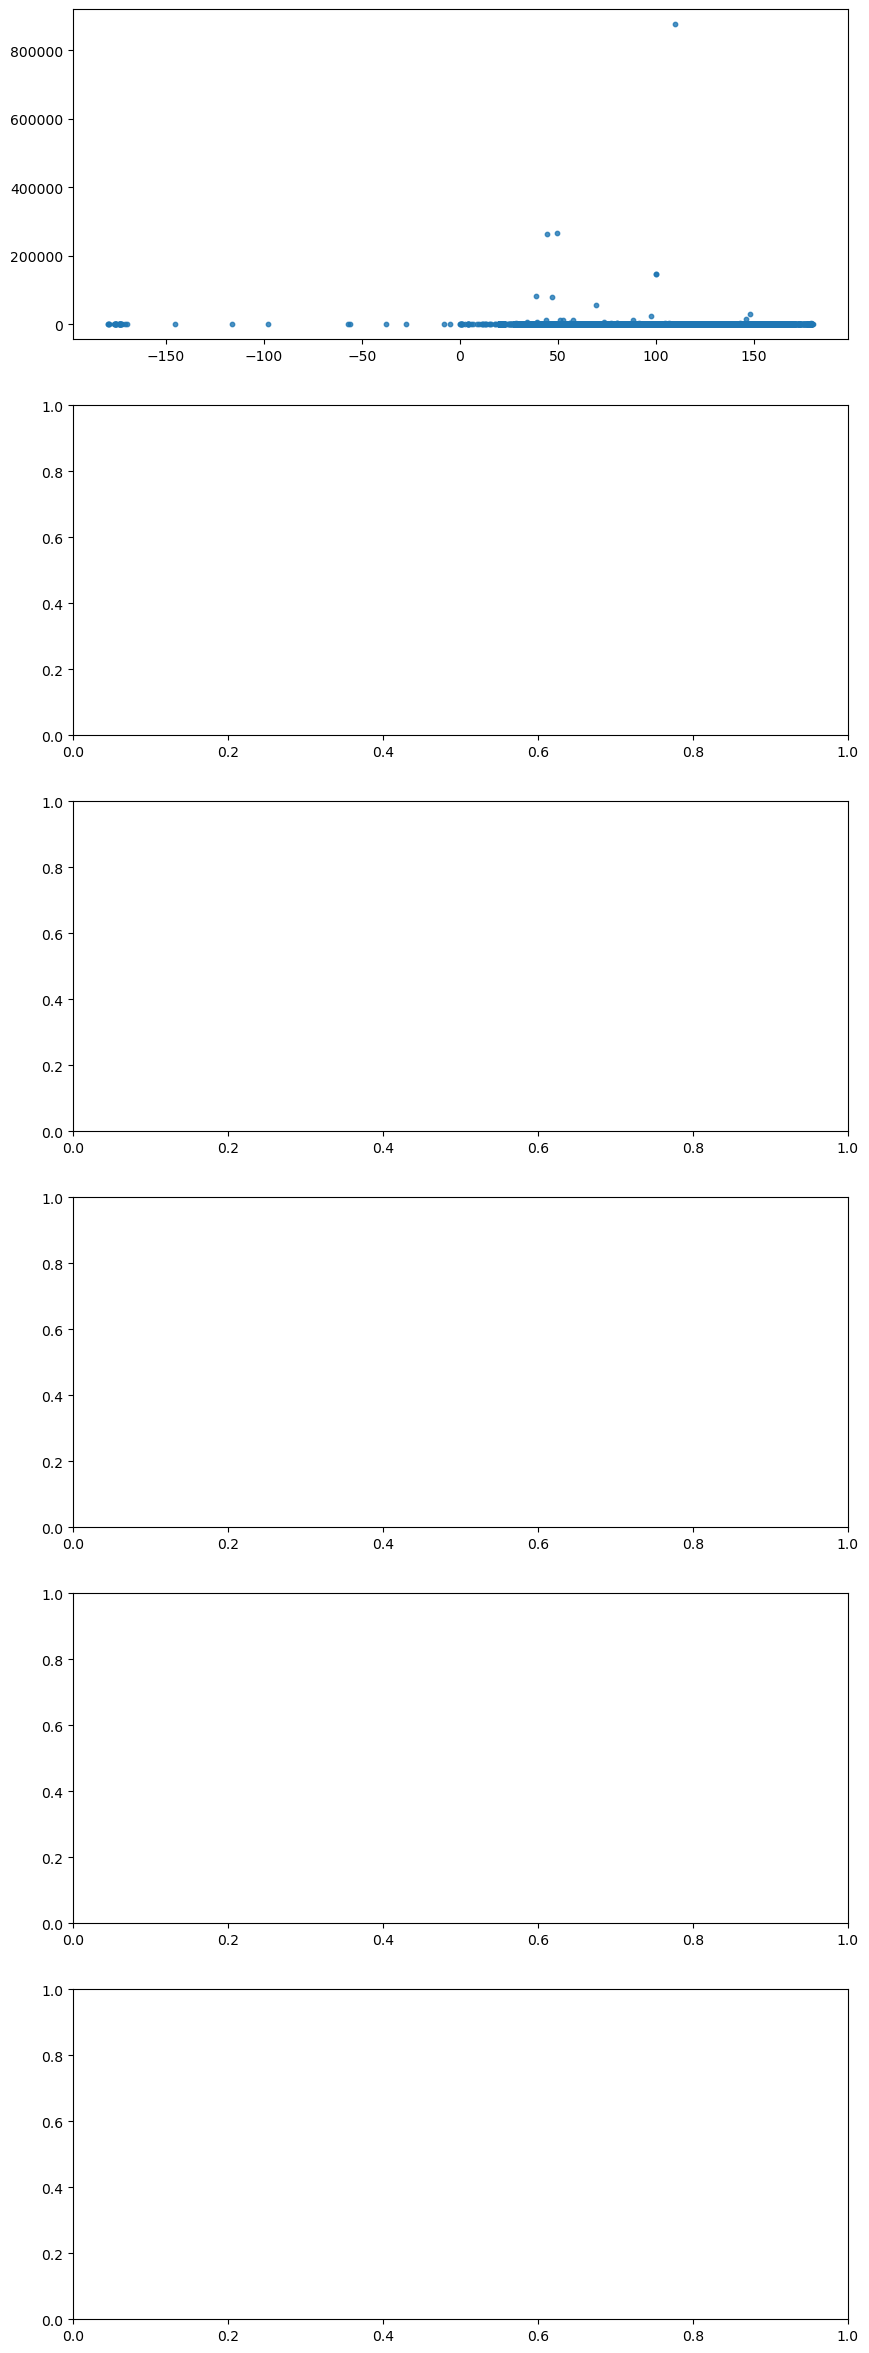

In [102]:
c = [ 'longitude', 'latitude']

#### Experiments

In [225]:


# URL веб-страницы, которую вы хотите спарсить
url = 'https://files.stroyinf.ru/Data1/9/9718/index.htm'

# Отправляем HTTP-запрос и получаем результат
response = requests.get(url)
web_content = response.text

# Создаем объект BeautifulSoup для парсинга HTML
soup = BeautifulSoup(web_content, 'html.parser')

# Находим все строки таблицы
rows = soup.find_all('tr')

# Словарь для хранения результатов без дубликатов
substances_info = OrderedDict()

# Перебираем все строки и извлекаем данные
for row in rows:
    # Находим все ячейки в строке
    cells = row.find_all('td')
    # Проверяем, что ячейки существуют и содержат только числа
    if len(cells) > 2 and cells[0].get_text(strip=True).isdigit() and cells[2].get_text(strip=True).isdigit():
        # Извлекаем код вещества и класс опасности
        substance_code = int(cells[0].get_text(strip=True))
        hazard_class = int(cells[2].get_text(strip=True))
        # Добавляем информацию в словарь, автоматически исключая дубликаты
        substances_info[(substance_code, hazard_class)] = None



for (code, hazard), _ in substances_info.items():
    print(f'Код вещества: {code}, Класс опасности: {hazard}')

# Выводим количество веществ с классом опасности
print(f'Количество веществ с классом опасности: {len(substances_info)}')

Код вещества: 1, Класс опасности: 5
Код вещества: 2, Класс опасности: 250
Код вещества: 3, Класс опасности: 73
Код вещества: 4, Класс опасности: 13
Код вещества: 5, Класс опасности: 37
Код вещества: 6, Класс опасности: 40
Код вещества: 7, Класс опасности: 21
Код вещества: 8, Класс опасности: 166
Код вещества: 9, Класс опасности: 130
Код вещества: 10, Класс опасности: 34
Код вещества: 11, Класс опасности: 154
Код вещества: 12, Класс опасности: 36
Код вещества: 13, Класс опасности: 30
Код вещества: 14, Класс опасности: 164
Код вещества: 15, Класс опасности: 12
Код вещества: 16, Класс опасности: 37
Код вещества: 17, Класс опасности: 144
Код вещества: 18, Класс опасности: 33
Код вещества: 19, Класс опасности: 104
Код вещества: 20, Класс опасности: 50
Код вещества: 21, Класс опасности: 10
Код вещества: 22, Класс опасности: 5
Код вещества: 23, Класс опасности: 148
Код вещества: 24, Класс опасности: 39
Код вещества: 25, Класс опасности: 14
Код вещества: 26, Класс опасности: 179
Код вещества: 

In [226]:
substances_info_dict = OrderedDict.fromkeys(substances_info)

# Convert back to a list and sort
# First, sort by substance code, then by hazard class
sorted_substances_info = sorted(substances_info_dict.keys(), key=lambda x: (x[0], x[1]))

# Now, sorted_substances_info contains sorted tuples without duplicates
for code, hazard in sorted_substances_info:
    print(f'Код вещества: {code}, Класс опасности: {hazard}')

Код вещества: 1, Класс опасности: 5
Код вещества: 2, Класс опасности: 250
Код вещества: 3, Класс опасности: 73
Код вещества: 4, Класс опасности: 13
Код вещества: 5, Класс опасности: 37
Код вещества: 6, Класс опасности: 40
Код вещества: 7, Класс опасности: 21
Код вещества: 8, Класс опасности: 166
Код вещества: 9, Класс опасности: 130
Код вещества: 10, Класс опасности: 34
Код вещества: 11, Класс опасности: 154
Код вещества: 12, Класс опасности: 36
Код вещества: 13, Класс опасности: 30
Код вещества: 14, Класс опасности: 164
Код вещества: 15, Класс опасности: 12
Код вещества: 16, Класс опасности: 37
Код вещества: 17, Класс опасности: 144
Код вещества: 18, Класс опасности: 33
Код вещества: 19, Класс опасности: 104
Код вещества: 20, Класс опасности: 50
Код вещества: 21, Класс опасности: 10
Код вещества: 22, Класс опасности: 5
Код вещества: 23, Класс опасности: 148
Код вещества: 24, Класс опасности: 39
Код вещества: 25, Класс опасности: 14
Код вещества: 26, Класс опасности: 179
Код вещества: 